# CME538 - Introduction to Data Science
**Project 2 - Toronto Bike Share**

**Team: Diligent Debuggers**

**Team members:** 

# Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import json
import time
import numpy as np
import datetime as dt
import codecs
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from io import StringIO
import pytz
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

/Users/brucehaoyuli/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Data Cleaning

## Get Station Data
Get the up to date bikeshare station information from `https://tor.publicbikesystem.net`.

In [2]:
response = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = pd.DataFrame(json.loads(response.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon', 'capacity']].astype({'station_id': 'int',})
bikeshare_stations = bikeshare_stations.rename(columns={'station_id': 'Station Id', 
                                                        'name': 'Station Name'})

# View DataFrame
bikeshare_stations.head(15)

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,26
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11
5,7005,King St W / York St,43.648001,-79.383177,19
6,7006,Bay St / College St (East Side),43.660439,-79.385525,19
7,7007,College St / Huron St,43.658148,-79.398167,19
8,7008,Wellesley St / Queen's Park Cres,43.663376,-79.392125,19
9,7009,King St E / Jarvis St,43.650325,-79.372287,25


In [3]:
bikeshare_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    655 non-null    int64  
 1   Station Name  655 non-null    object 
 2   lat           655 non-null    float64
 3   lon           655 non-null    float64
 4   capacity      655 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 25.7+ KB


In [4]:
bikeshare_stations.nunique()

Station Id      655
Station Name    655
lat             653
lon             654
capacity         37
dtype: int64

The station dataframe has no missing/duplicated station name or id. 

In [5]:
# Write bikeshare station dataframe to a csv file
path_stations = os.path.join(os.path.abspath(os.getcwd()), 'data', 'stations')
bikeshare_stations.to_csv(os.path.join(path_stations, 'bikeshare_stations.csv'))

## Weather Data

### Load Weather Data

In [6]:
# Set weather data path
path_weather = os.path.join(os.path.abspath(os.getcwd()), 'data', 'weather')

# Get weather file names
weather_filenames = [filename for filename in os.listdir(path_weather) if 'climate' in filename]

# Print file names
print(weather_filenames[0:5])

['en_climate_hourly_ON_6158359_11-2021_P1H.csv', 'en_climate_hourly_ON_6158359_08-2022_P1H.csv', 'en_climate_hourly_ON_6158359_03-2021_P1H.csv', 'en_climate_hourly_ON_6158359_04-2021_P1H.csv', 'en_climate_hourly_ON_6158359_04-2017_P1H.csv']


In [7]:
# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
weather_data = {filename: pd.read_csv(os.path.join(path_weather, filename)) for filename in weather_filenames}  

In [8]:
weather_rename = {
    'Date/Time (LST)' : 'Date/Time',
    'Time (LST)' : 'Time',
}

for filename in weather_filenames:
    weather_data[filename].rename(columns=weather_rename, inplace=True)

In [9]:
# Import weather
weather = pd.concat([weather_data[filename] for filename in weather_filenames], ignore_index=True)

# View DataFrame
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 00:00,2021,11,1,00:00,9.3,...,NaN,16.1,NaN,100.10,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 01:00,2021,11,1,01:00,8.5,...,NaN,16.1,NaN,100.21,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 02:00,2021,11,1,02:00,8.0,...,NaN,16.1,NaN,100.29,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 03:00,2021,11,1,03:00,7.7,...,NaN,16.1,NaN,100.41,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2021-11-01 04:00,2021,11,1,04:00,7.0,...,NaN,16.1,NaN,100.50,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        49656 non-null  float64
 1   Latitude (y)         49656 non-null  float64
 2   Station Name         49656 non-null  object 
 3   Climate ID           49656 non-null  int64  
 4   Date/Time            49656 non-null  object 
 5   Year                 49656 non-null  int64  
 6   Month                49656 non-null  int64  
 7   Day                  49656 non-null  int64  
 8   Time                 49656 non-null  object 
 9   Temp (°C)            49273 non-null  float64
 10  Temp Flag            331 non-null    object 
 11  Dew Point Temp (°C)  49012 non-null  float64
 12  Dew Point Temp Flag  593 non-null    object 
 13  Rel Hum (%)          49026 non-null  float64
 14  Rel Hum Flag         579 non-null    object 
 15  Precip. Amount (mm)  15318 non-null 

### Drop Redundant Columns

Apart from the unnecessary columns specified in proposal, 'Stn Press (kPa)' is not important because small atmospheric pressure changes have infinitesimal effects on everyday activities.

In [11]:
weather_clean = weather.drop(['Year', 'Month', 'Day', 'Time', 'Station Name', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Stn Press (kPa)'], axis=1)

* The 'Date/Time' column need to be converted to datetime variable and localized to 'EST' timezone.
* The 'Weather' column is the visual observation of the weather environment and appears to be important. The missing values in this column means a clear weather. So missing values should be assigned with 'Clear'.
* There are a number of columns containing the word 'Flag', and only contains NaN or 'M' values. According to Environment and Climate Change Canada, the 'M' represents 'missing' which means the data is unretrievable or unavailable. The flag columns can be removed since they only contain overlapping information.

In [12]:
# Look for and drop the columns containing the word 'Flag'
flag_columns = [col for col in weather.columns if 'Flag' in col]
weather_clean = weather_clean.drop(flag_columns, axis = 1)

In [13]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date/Time            49656 non-null  object 
 1   Temp (°C)            49273 non-null  float64
 2   Dew Point Temp (°C)  49012 non-null  float64
 3   Rel Hum (%)          49026 non-null  float64
 4   Precip. Amount (mm)  15318 non-null  float64
 5   Wind Dir (10s deg)   46833 non-null  float64
 6   Wind Spd (km/h)      49581 non-null  float64
 7   Visibility (km)      49570 non-null  float64
 8   Hmdx                 8134 non-null   float64
 9   Wind Chill           8862 non-null   float64
 10  Weather              7442 non-null   object 
dtypes: float64(9), object(2)
memory usage: 4.2+ MB


In [14]:
weather_clean['Weather'].unique()

array([nan, 'Rain', 'Fog', 'Moderate Rain', 'Rain,Fog', 'Snow', 'Haze',
       'Thunderstorms', 'Thunderstorms,Rain', 'Thunderstorms,Rain,Fog',
       'Moderate Rain,Fog', 'Rain,Snow', 'Freezing Rain,Snow',
       'Moderate Snow', 'Heavy Rain,Fog', 'Thunderstorms,Moderate Rain',
       'Thunderstorms,Fog', 'Thunderstorms,Heavy Rain,Fog',
       'Freezing Rain,Fog', 'Freezing Rain',
       'Thunderstorms,Moderate Rain,Fog', 'Thunderstorms,Heavy Rain',
       'Snow,Blowing Snow', 'Heavy Snow', 'Haze,Blowing Snow'],
      dtype=object)

### Datetime data

In [15]:
# Convert 'Date/Time' column to datetime variables
weather_clean['Date/Time'] = pd.to_datetime(weather_clean['Date/Time']).dt.tz_localize('US/Eastern', ambiguous=True, nonexistent='shift_backward')

In [16]:
weather_clean = weather_clean.set_index('Date/Time')
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,,
2021-11-01 00:00:00-04:00,9.3,3.1,65.0,0.0,29.0,30.0,16.1,NaN,NaN,NaN
2021-11-01 01:00:00-04:00,8.5,3.1,69.0,0.0,28.0,24.0,16.1,NaN,NaN,NaN
2021-11-01 02:00:00-04:00,8.0,1.4,63.0,0.0,29.0,28.0,16.1,NaN,NaN,NaN
2021-11-01 03:00:00-04:00,7.7,1.1,63.0,0.0,28.0,24.0,16.1,NaN,NaN,NaN
2021-11-01 04:00:00-04:00,7.0,0.7,64.0,0.0,27.0,21.0,16.1,NaN,NaN,NaN


### Missing Values

In [17]:
# Check missing values
display(weather_clean.isnull().sum(axis=0).to_frame('count'))

,count
Temp (°C),383
Dew Point Temp (°C),644
Rel Hum (%),630
Precip. Amount (mm),34338
Wind Dir (10s deg),2823
Wind Spd (km/h),75
Visibility (km),86
Hmdx,41522
Wind Chill,40794
Weather,42214


'Hmdx', 'Wind Chill', and 'Weather' columns have significantly more missing values than the other columns.

In [18]:
# Check missing values for each year
display(weather_clean.resample('Y').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,,
2017-12-31 00:00:00-05:00,11,11,10,8760,530,9,11,7599,7251,7390
2018-12-31 00:00:00-05:00,4,4,2,8760,504,2,4,6979,7084,7336
2019-12-31 00:00:00-05:00,95,145,145,8760,595,23,24,7608,6936,7213
2020-12-31 00:00:00-05:00,13,12,7,8040,426,14,16,7211,7599,7494
2021-12-31 00:00:00-05:00,26,52,47,14,476,21,16,7307,7383,7624
2022-12-31 00:00:00-05:00,234,420,419,4,292,6,15,4818,4541,5157


#### **Imputing/filling Hmdx and Wind Chill missing values**

According to Environment and Climate Change Canada (https://climate.weather.gc.ca/glossary_e.html), the humidex values are only reported if:

  (1) air temperature is greater than or equal to 20 degrees celsius and,
  
  (2) the humidex value is at least 1 degree greater than the air temperature. 
  
Similarily, wind chill is only calculated if the air temperature is greater than or equal to 0 degrees celsius.

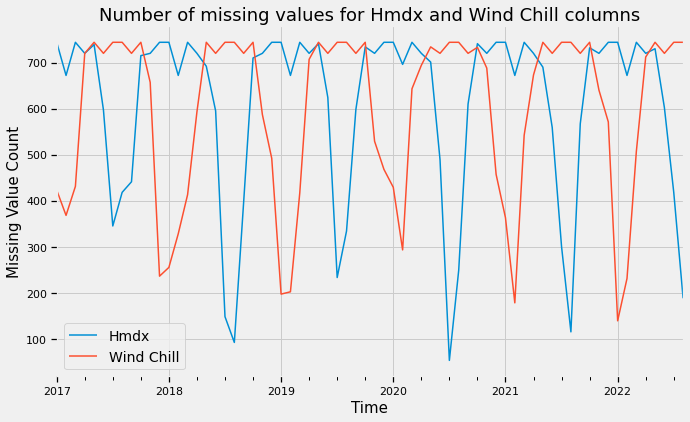

In [19]:
# Visualizing number of missing values in 'Hmdx' and 'Wind Chill' columns
weather_clean.resample('M').agg(lambda row: row.isnull().sum())[['Hmdx', 'Wind Chill']].plot(figsize = (10, 6))

plt.title('Number of missing values for Hmdx and Wind Chill columns', fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Missing Value Count', fontsize = 15)
plt.legend(['Hmdx', 'Wind Chill'], fontsize = 14)

We can find that there are more missing wind chill values and fewer missing humidex values in the summer, and vice versa in the winter. This agrees with the explanation provided by Environment and Climate Change Canada.

Therefore, the missing values in 'Hmdx' and 'Wind Chill' should not be modified.

#### **Imputing/filling Weather missing values**

In [20]:
# Modifying missing values in 'Weather' column
weather_clean['Weather'].fillna('Clear', inplace = True)
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,,
2021-11-01 00:00:00-04:00,9.3,3.1,65.0,0.0,29.0,30.0,16.1,NaN,NaN,Clear
2021-11-01 01:00:00-04:00,8.5,3.1,69.0,0.0,28.0,24.0,16.1,NaN,NaN,Clear
2021-11-01 02:00:00-04:00,8.0,1.4,63.0,0.0,29.0,28.0,16.1,NaN,NaN,Clear
2021-11-01 03:00:00-04:00,7.7,1.1,63.0,0.0,28.0,24.0,16.1,NaN,NaN,Clear
2021-11-01 04:00:00-04:00,7.0,0.7,64.0,0.0,27.0,21.0,16.1,NaN,NaN,Clear


#### **Imputing/filling missing values for other columns**

The weather data is sampled every hour, so it should be reasonable to impute missing values based on the time-adjacent valid observations. Except for 'Hmdx', 'Wind Chill', and 'Weather' columns, all other columns will have missing values filled using linear interpolation between valid observations.

In [21]:
# Linear interpolating values 
interpolating_col = weather_clean.columns.drop(['Hmdx', 'Wind Chill', 'Weather'])
weather_clean[interpolating_col] = weather_clean[interpolating_col].interpolate(
    method = 'linear', axis = 0, limit_direction = 'both').round(1)

In [22]:
# Check if there are still missing values
weather_clean.isnull().sum(axis=0).to_frame('count')

,count
Temp (°C),0
Dew Point Temp (°C),0
Rel Hum (%),0
Precip. Amount (mm),0
Wind Dir (10s deg),0
Wind Spd (km/h),0
Visibility (km),0
Hmdx,41522
Wind Chill,40794
Weather,0


### Outliers

Check if there are outliers for temperature.

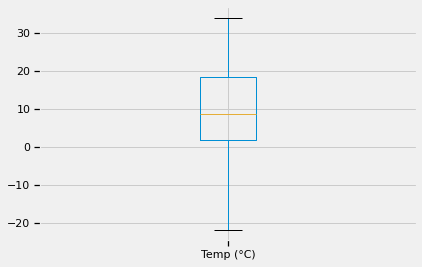

In [23]:
# draw boxplots to visualize outliers
plt.figure()
weather_clean.boxplot(column='Temp (°C)')
plt.show()

There is no need to remove outliers. The weather data is cleaned!

In [24]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49656 entries, 2021-11-01 00:00:00-04:00 to 2020-12-31 23:00:00-05:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp (°C)            49656 non-null  float64
 1   Dew Point Temp (°C)  49656 non-null  float64
 2   Rel Hum (%)          49656 non-null  float64
 3   Precip. Amount (mm)  49656 non-null  float64
 4   Wind Dir (10s deg)   49656 non-null  float64
 5   Wind Spd (km/h)      49656 non-null  float64
 6   Visibility (km)      49656 non-null  float64
 7   Hmdx                 8134 non-null   float64
 8   Wind Chill           8862 non-null   float64
 9   Weather              49656 non-null  object 
dtypes: float64(9), object(1)
memory usage: 4.2+ MB


## Bike Share Trip Data

### Load Bike Share Trip Data

In [25]:
# Define the rubbish character in front of the 'trip id' columns in some files
rubbish = ''.join([chr(c) for c in codecs.BOM_UTF8])

def read_bikeshare_csv(path):
    """
    Create a function to read bike share trips csv files without the rubbish character.
    """
    with open(path, encoding='utf-8') as f:
        txt = f.read()
        if txt.startswith(rubbish):
            txt = txt[len(rubbish):]
            
        return pd.read_csv(StringIO(txt), encoding='utf-8', encoding_errors='ignore')

In [26]:
# Set bikeshare data path
path_ridership = os.path.join(os.path.abspath(os.getcwd()), 'data', 'ridership')

# Create a list of file names for bike share trips data
trips_filenames = [filename for filename in os.listdir(path_ridership) if 'bike_share' in filename]

# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
trips_data = {filename: read_bikeshare_csv(os.path.join(path_ridership, filename)) for filename in trips_filenames}  

In [27]:
# Check the column names of all files
for filename in trips_filenames:
    print(format(trips_data[filename].columns.tolist()))

['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
['Trip Id', 'Subscription Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike Id', 'User Type']
['Trip Id', 'Trip  Duration', 'Start Station Id', 'Start Time', 'Start Station Name', 'End Station Id', 'End Time', 'End Station Name', 'Bike I

In [28]:
# Rename the columns in 2017 and 2018 data
trips_rename = {
    'trip_id' : 'Trip Id',
    'trip_start_time' : 'Start Time',
    'trip_stop_time' : 'End Time',
    'trip_duration_seconds' : 'Trip Duration',
    'from_station_id' : 'Start Station Id',
    'from_station_name' : 'Start Station Name',
    'to_station_id' : 'End Station Id',
    'to_station_name' : 'End Station Name',
    'user_type' : 'User Type'
}

for filename in trips_filenames:
    if ('2017' in filename) or ('2018' in filename):
        trips_data[filename].rename(columns=trips_rename, inplace=True)
    else:
        trips_data[filename].rename(columns={'Trip  Duration' : 'Trip Duration'}, inplace=True)

In [29]:
# Concatenate the ridership data into one dataframe 
ridership = pd.concat([trips_data[filename] for filename in trips_filenames], ignore_index=True)

# View DataFrame
ridership.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Subscription Id
0,16734202,1602,7216.0,01/07/2022 00:00:00 (EST),Wellington St W / Stafford St,7203.0,01/07/2022 00:26:00 (EST),Bathurst St/Queens Quay(Billy Bishop Airport),6420.0,Casual Member,NaN
1,16734203,990,7033.0,01/07/2022 00:00:00 (EST),Union Station,7474.0,01/07/2022 00:16:00 (EST),Clarence Square,2092.0,Casual Member,NaN
2,16734204,653,7184.0,01/07/2022 00:00:00 (EST),Ossington Ave / College St,7368.0,01/07/2022 00:11:00 (EST),Lisgar St / Dundas St SMART,4220.0,Annual Member,NaN
3,16734205,811,7199.0,01/07/2022 00:00:00 (EST),College St / Markham St,7533.0,01/07/2022 00:13:00 (EST),Housey St / Dan Leckie Way,663.0,Annual Member,NaN
4,16734206,1003,7033.0,01/07/2022 00:00:00 (EST),Union Station,7474.0,01/07/2022 00:17:00 (EST),Clarence Square,553.0,Casual Member,NaN


In [30]:
ridership.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15358993 entries, 0 to 15358992
Data columns (total 11 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Trip Id             15358993 non-null  int64  
 1   Trip Duration       15358993 non-null  int64  
 2   Start Station Id    14332100 non-null  float64
 3   Start Time          15358993 non-null  object 
 4   Start Station Name  15262057 non-null  object 
 5   End Station Id      14327681 non-null  float64
 6   End Time            15358992 non-null  object 
 7   End Station Name    15256259 non-null  object 
 8   Bike Id             11943393 non-null  float64
 9   User Type           15358993 non-null  object 
 10  Subscription Id     5052221 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ GB


In [31]:
ridership['User Type'].unique()

array(['Casual Member', 'Annual Member', 'Member', 'Casual'], dtype=object)

**Problems in the dataset:**
* There are a lot of null values, especially in station id and station name columns. 
* Start Time and End Time values need to be first converted into datatime variables with timezone info and then converted to 'US/Eastern' timezone.
* User Types need to be unified in one format.
* Subscription Id and Bike Id are only included in some years and are less useful information. So they need to be dropped.
* There is one missing value in End Time column.

### Preprocessing

**Drop unwanted columns**

In [32]:
#Drop Bike ID and Subscription ID columns
ridership.drop(['Subscription Id', 'Bike Id'], axis=1, inplace=True)

**Unify user type formats**

In [33]:
user_rename = {
    'Annual Member' : 'Member',
    'Casual Member' : 'Casual'
}

ridership['User Type'].replace(user_rename, inplace=True)

**Set Trip ID to index**

In [34]:
#Set Trip ID to index
ridership.set_index('Trip Id')

,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,
16734202,1602,7216.0,01/07/2022 00:00:00 (EST),Wellington St W / Stafford St,7203.0,01/07/2022 00:26:00 (EST),Bathurst St/Queens Quay(Billy Bishop Airport),Casual
16734203,990,7033.0,01/07/2022 00:00:00 (EST),Union Station,7474.0,01/07/2022 00:16:00 (EST),Clarence Square,Casual
16734204,653,7184.0,01/07/2022 00:00:00 (EST),Ossington Ave / College St,7368.0,01/07/2022 00:11:00 (EST),Lisgar St / Dundas St SMART,Member
16734205,811,7199.0,01/07/2022 00:00:00 (EST),College St / Markham St,7533.0,01/07/2022 00:13:00 (EST),Housey St / Dan Leckie Way,Member
16734206,1003,7033.0,01/07/2022 00:00:00 (EST),Union Station,7474.0,01/07/2022 00:17:00 (EST),Clarence Square,Casual
...,...,...,...,...,...,...,...,...
868761,577,7021.0,2017-04-01 04:42 (UTC),Bay St / Albert St,7024.0,2017-04-01 04:52 (UTC),Dundonald St / Church St,Member
868762,292,7069.0,2017-04-01 04:50 (UTC),Queen St W / Spadina Ave,7037.0,2017-04-01 04:55 (UTC),Bathurst St / Dundas St W,Member
868763,709,7010.0,2017-04-01 04:51 (UTC),King St W / Spadina Ave,7060.0,2017-04-01 05:02 (UTC),Princess St / Adelaide St,Member


**Drop the row with null End Time**

In [35]:
ridership[ridership['End Time'].isnull()==True]

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
9754385,2302635,0,NaN,2017-11-29 10:53 (UTC),Seaton St / Dundas St E,NaN,NaN,NaN,Casual


In [36]:
#Drop the row with null End Time
ridership = ridership[ridership['End Time'].isnull()==False]

**Check on duplicate trip records**

In [37]:
# Check if there are duplicate trips
ridership['Trip Id'].nunique() / len(ridership)

0.9999991535902877

In [38]:
trip_duplicates = ridership[ridership.duplicated('Trip Id')]
trip_duplicates

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
6763683,12272296,0,7090.0,29/06/2021 23:59:00 (EST),Danforth Ave / Lamb Ave,7156.0,29/06/2021 23:59:00 (EST),Salem Ave / Bloor St W,Member
6764962,12273983,0,7078.0,30/06/2021 08:47:00 (EST),College St / Major St,7339.0,30/06/2021 08:47:00 (EST),Carlaw Ave / Strathcona Ave,Member
6770921,12281090,0,7101.0,30/06/2021 17:24:00 (EST),Lower Sherbourne St / The Esplanade,7014.0,30/06/2021 17:24:00 (EST),Sherbourne St / Carlton St (Allan Gardens),Casual
7984479,11180718,0,7271.0,18/04/2021 15:50:00 (EST),Yonge St / Alexander St - SMART,7267.0,18/04/2021 15:50:00 (EST),Dundas St E / Pembroke St - SMART,Member
8020463,11224466,0,7649.0,24/04/2021 14:14:00 (EST),Greenwood Subway Station - SMART,7611.0,24/04/2021 14:14:00 (EST),Victoria Park Ave / Danforth Ave,Member
8028339,11233036,0,7017.0,24/04/2021 18:09:00 (EST),Widmer St / Adelaide St W,7634.0,24/04/2021 18:09:00 (EST),University Ave / Gerrard St W (WEST) - SMART,Casual
8530765,10909571,0,7351.0,18/03/2021 17:32:00 (EST),Pretoria Av / Broadview Av,7286.0,18/03/2021 17:32:00 (EST),Gerrard St E / Broadview - SMART,Member
8563120,10947892,0,7119.0,22/03/2021 19:02:00 (EST),Sumach St / Carlton St. (Riverdale Farm),7458.0,22/03/2021 19:02:00 (EST),Church St / Lombard St,Casual
8568848,10954749,0,7254.0,23/03/2021 17:49:00 (EST),Borden St / Bloor St W - SMART,7023.0,23/03/2021 17:49:00 (EST),College St / Borden St,Member
8599519,10991914,0,7248.0,28/03/2021 17:45:00 (EST),Baldwin Ave / Spadina Ave - SMART,7020.0,28/03/2021 17:45:00 (EST),Phoebe St / Spadina Ave,Casual


The duplicated trips have trip duration of 0 second, which means they are probably produced due to errors. And they will be removed later when removing trip duration outliers. So there is no need to deal with them at this moment.

### Split ridership data for different years 
The ridership data is splited into small dataframes for different years for better preliminary analyze and data cleaning.

In [39]:
# Separate ridership data according to year
ridership_2017 = ridership.loc[ridership['Start Time'].str.contains('2017')]
ridership_2018 = ridership.loc[ridership['Start Time'].str.contains('2018')]
ridership_2019 = ridership.loc[ridership['Start Time'].str.contains('2019')]
ridership_2020 = ridership.loc[ridership['Start Time'].str.contains('2020')]
ridership_2021 = ridership.loc[ridership['Start Time'].str.contains('2021')]
ridership_2022 = ridership.loc[ridership['Start Time'].str.contains('2022')]

### Datetime data
Since we are going to conduct datetime convert for each year, we can define a function. 
There are two formats in the datetime columns in all ridership data, we need to treat them separately for different timezones, also because pd.to_datetime can't deal with mixed time formats:
* When there is a str "UTC" in the Time columns, it means that the data was downloaded as UTC time, therefore it is first localized to UTC timezone and then converted to US/Eastern timezone.
* When there is a str "EST" in the Time columns, it means that the data was downloaded as EST time, therefore it should be localized to US/Eastern timezone.

The Daylight Saving Time (DST) is set to be true since the bikeshare data is collected in Toronto.

In [40]:
# Create a time_convert function to convert Start Time and End Time into datetime variables
def time_convert(df):
    """Convert Start Time and End Time into datetime variables
    Using pd.to_datetime for each specific time format. DST is set to be True.
    """
    df_copy = df.copy()

    if 'UTC' in df_copy['Start Time'].iloc[0]:
        df_copy['Start Time'] = pd.to_datetime(df['Start Time'].str[:16])\
            .dt.tz_localize('UTC', ambiguous=True, nonexistent='shift_backward')\
                .dt.tz_convert('US/Eastern')
        df_copy['End Time'] = pd.to_datetime(df['End Time'].str[:16])\
            .dt.tz_localize('UTC', ambiguous=True, nonexistent='shift_backward')\
                .dt.tz_convert('US/Eastern')
    else:
        df_copy['Start Time'] = pd.to_datetime(df['Start Time'].str[:16])\
            .dt.tz_localize('US/Eastern', ambiguous=True, nonexistent='shift_backward')
        df_copy['End Time'] = pd.to_datetime(df['End Time'].str[:16])\
            .dt.tz_localize('US/Eastern', ambiguous=True, nonexistent='shift_backward')
   
    return df_copy

### Missing Values

After converting the datetime values, the dataframe is stored in dataframes named `ridership_est` with year suffixes. Then the data of each year is cleaned accordingly. 

First we create a function to remove the rows with 'Trip Duration' outliers. Normally trips shorter than 60 sec are considered non-existent, so we can safely remove these trips. Then we also print out the percent of outliers removed to know the data structure better. 

In [41]:
# Create a remove_outliers function to remove the rows with trip duration outliers.
def remove_outliers(data):
    """
    Create a function tto remove the rows with trip duration outliers in the dataset
    The input data is a dataframe with column named 'Trip Duration'.
    """

    data_len = len(data)

    # Narrow down our dataset with 60 seconds duration filter
    data = data[data['Trip Duration']>=60]
    
    # Compute quartiles
    Q1 = data ['Trip Duration'].quantile(0.25)
    Q3 = data ['Trip Duration'].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data['Trip Duration']<=(Q3+1.5*IQR)) & (data['Trip Duration']>=(Q1-1.5*IQR))]

    print("Percent of outliers removed: {}%".format((1-len(data) / data_len) * 100))
    
    return data

#### **2017 Data**

In [42]:
ridership_est_2017 = time_convert(ridership_2017)

In [43]:
# Create a functio to plot distribution of a variable in a dataframe
def plot_distribution(var, df):
    """
    The function takes two input. 
    df (dataframe).
    var (str) : it is a column name in df.
    """

    sns.boxplot(x=var, data=df)
    plt.xlabel(var)
    plt.title('Distribution of {} '.format(var))
    plt.show()

    return


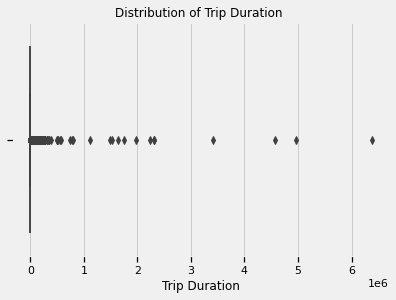

In [44]:
plot_distribution('Trip Duration', ridership_est_2017)

In [45]:
# Remove trip duration outliers
ridership_est_2017 = remove_outliers(ridership_est_2017)

Percent of outliers removed: 7.65510161413967%


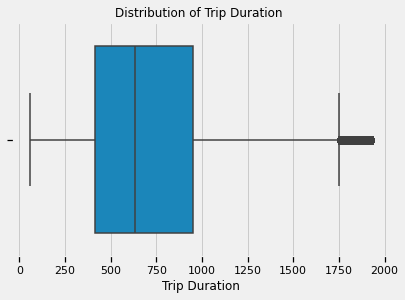

In [46]:
plot_distribution('Trip Duration', ridership_est_2017)

In [47]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Trip Duration              0
Start Station Id      934205
Start Time                 0
Start Station Name         0
End Station Id        934205
End Time                   0
End Station Name           0
User Type                  0
dtype: int64

The missing Station Id can probably be filled using the Station Data. Let's first check out what does these trip look like.

In [48]:
#The trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003950,1485285,290,NaN,2017-08-01 01:00:00-04:00,University Ave / Elm St,NaN,2017-08-01 01:04:00-04:00,College St / Huron St,Member
4003951,1485286,311,NaN,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,NaN,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member
4003952,1485287,1053,NaN,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,NaN,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member
4003953,1485288,502,NaN,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,NaN,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member
4003954,1485289,803,NaN,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,NaN,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member


We will use station data as a reference to find missing Station Id. Since this process will probably be conducted multiple times for different year data, we create a function `fill_id` to do so.

In [49]:
# Create a fill_id function for filling missing station ID according to station name
def fill_id(df):
    """This function is for filling missing station names according to station ID
    using the bikeshare_stations data as reference.
    """
    
    df['Start Station Id'].fillna(
        df['Start Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    df['End Station Id'].fillna(
        df['End Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    return df

Also, we create a `fill_name` function to find the missing station names according to station ID using the station data as a reference.

In [50]:
# Create a fill_name function for filling missing station name according to station ID
def fill_name(df):
    """This function is for filling missing station names according to station ID.
    using the bikeshare_stations as reference.
    """

    df['Start Station Name'].fillna(
        df['Start Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    df['End Station Name'].fillna(
        df['End Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    return df

In [51]:
fill_id(ridership_est_2017)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003950,1485285,290,7004.0,2017-08-01 01:00:00-04:00,University Ave / Elm St,7007.0,2017-08-01 01:04:00-04:00,College St / Huron St,Member
4003951,1485286,311,7197.0,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,7046.0,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member
4003952,1485287,1053,7196.0,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,7128.0,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member
4003953,1485288,502,7107.0,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,7067.0,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member
4003954,1485289,803,7195.0,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,7163.0,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member
...,...,...,...,...,...,...,...,...,...
15358988,868761,577,7021.0,2017-04-01 00:42:00-04:00,Bay St / Albert St,7024.0,2017-04-01 00:52:00-04:00,Dundonald St / Church St,Member
15358989,868762,292,7069.0,2017-04-01 00:50:00-04:00,Queen St W / Spadina Ave,7037.0,2017-04-01 00:55:00-04:00,Bathurst St / Dundas St W,Member
15358990,868763,709,7010.0,2017-04-01 00:51:00-04:00,King St W / Spadina Ave,7060.0,2017-04-01 01:02:00-04:00,Princess St / Adelaide St,Member
15358991,868764,699,7058.0,2017-04-01 00:53:00-04:00,Huron/ Harbord St,7057.0,2017-04-01 01:04:00-04:00,Simcoe St / Wellington St W,Member


In [52]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Trip Duration              0
Start Station Id      236883
Start Time                 0
Start Station Name         0
End Station Id        241751
End Time                   0
End Station Name           0
User Type                  0
dtype: int64

Missing Station Id can be largely reduced using `fill_id`, yet there are still lots of missing values. So we'd like to look at these rows again.

In [53]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003956,1485291,1214,7169.0,2017-08-01 01:08:00-04:00,Front St W / Bay St (North Side),NaN,2017-08-01 01:29:00-04:00,Spadina Ave / Sussex Ave,Member
4003957,1485292,199,7046.0,2017-08-01 01:09:00-04:00,Niagara St / Richmond St W,NaN,2017-08-01 01:12:00-04:00,Queen St W / Portland St,Member
4003958,1485293,366,NaN,2017-08-01 01:11:00-04:00,Parliament St / Aberdeen Ave,7024.0,2017-08-01 01:17:00-04:00,Dundonald St / Church St,Member
4003967,1485302,1136,NaN,2017-08-01 01:16:00-04:00,Bay St / Bloor St W,7176.0,2017-08-01 01:35:00-04:00,Bathurst St / Fort York Blvd,Casual
4003968,1485303,438,7044.0,2017-08-01 01:17:00-04:00,Church St / Alexander St,NaN,2017-08-01 01:24:00-04:00,Seaton St / Dundas St E,Casual


The remaining missing values are because there are inconsistency issues with the station names. Some of the stations names can't be found in `bikeshare_stations` data possibly due to station upgrade or typos. For example, the station shown above named "Beverly St / College St" actually have a correct name "Beverley St / College St" in the `bikeshare_stations` data. So we need to update the Station Names based on `bikeshare_stations` data, replacing all messy station names to their most updated names. Meanwhile we also want to avoid mistakenly matching stations with similar names but are actually not the same stations. A good way to do it is to match messy names with new names using their only station ID.

In [54]:
# Obtain an updated station name list from bikeshare_stations dataset
station_names = bikeshare_stations['Station Name'].unique()

The stations without Station ID may not have exact matched names in bikeshare_station data, but we can probably find entries with the same names in ridership data that has Station ID. Since one station ID may relate to multiple messy names, but one station can only have one station ID. We can then use this ID to find the updated name for each station.

In [55]:
# Create a dataframe stations_old to store all old (messy) names and their relating station ID from the ridership dataframe.
# Extract both starting station names and ending station names from the ridership dataframe as old station names
stations_start = ridership[['Start Station Id', 'Start Station Name']]
stations_end = ridership[['End Station Id', 'End Station Name']]
stations_start.columns = stations_end.columns = ['Station Id', 'Station Name']

# Combine the stations into a single dataframe stations_old
stations_old = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)
stations_old = stations_old.dropna(subset='Station Name')

# Drop rows with duplicate station names, keeping the one with a Station Id
stations_old = stations_old.sort_values(['Station Id'], na_position='last').drop_duplicates('Station Name', keep='first')

In [56]:
stations_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 86 to 1057
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    807 non-null    float64
 1   Station Name  817 non-null    object 
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


In [57]:
stations_old.nunique()

Station Id      626
Station Name    817
dtype: int64

It seems that there are 817 unique old (messy) stations names in all ridership dataset while the station ID is less than that. Which means we do have a lot of stations that are represented by multiple station names in the ridership data. 

There are also 10 station names that don't have a relating station ID in the ridership dataset. We can try filling these ID for these station names in order to find their new station names later.

In [58]:
# try finding the stations with missing ID using bikeshare_stations data
stations_old['Station Id'].fillna(
    stations_old['Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
    inplace=True)

In [59]:
# Separate the stations names that has no station ID
stations_old_ID = stations_old[stations_old['Station Id'].isnull()==False]
stations_old_noID = stations_old[stations_old['Station Id'].isnull()==True]
stations_old_noID

,Station Id,Station Name
800,NaN,Michael Sweet Ave / St. Patrick St
833,NaN,Beverly St / College St
861,NaN,Margueretta St / College St
929,NaN,Lansdowne Subway Green P
991,NaN,Roxton Rd / College St
993,NaN,Base Station
999,NaN,Lake Shore Blvd W / Ontario Dr(Ontario Place)
1049,NaN,Dovercourt Rd / Harrison St - SMART
1051,NaN,Summerhill Ave / MacLennan Ave - SMART
1057,NaN,Fringe Next Stage - 7219


These stations may have new names in the updated bikeshare_stations data. So we can use `fuzzywuzzy` to find their possible new name and then try to fill their missing ID accordingly.

In [60]:
# Create a find_fuzz function for find the updated station names using fuzz.
# We use token sort ratio from fuzz to match two similar strings as possible pairs
# of old and new station names. If the order in which the words are placed in 
# a particular sentence doesn’t matter then the best way to match two strings 
# is by the use of Token Sort Ratio.

def find_fuzz(old_name, station_names):
    """This function find a new_name in the bikeshare_station dataset
    for an old_name using the fuzzywuzzy.
    """
    # When the matching score is below threshold, the output is 'No Match Station'
    result_dict  = {0: 'No Match Station'}
    
    if old_name in station_names:
        return old_name
    else:
        for new_name in station_names:
            if fuzz.token_sort_ratio(new_name,old_name) >= 80:
                result_dict[fuzz.token_sort_ratio(new_name,old_name)] = str(new_name)
    
    result = result_dict[max(result_dict.keys())]
    
    return result

In [61]:
# find possible new names for the stations with no ID
find_fuzzname = stations_old_noID.copy()
find_fuzzname['possible_new_name'] = find_fuzzname['Station Name'].apply(lambda row: find_fuzz(row, station_names))
find_fuzzname

,Station Id,Station Name,possible_new_name
800,NaN,Michael Sweet Ave / St. Patrick St,No Match Station
833,NaN,Beverly St / College St,Beverley St / College St
861,NaN,Margueretta St / College St,No Match Station
929,NaN,Lansdowne Subway Green P,No Match Station
991,NaN,Roxton Rd / College St,No Match Station
993,NaN,Base Station,No Match Station
999,NaN,Lake Shore Blvd W / Ontario Dr(Ontario Place),Lake Shore Blvd W / Ontario Dr
1049,NaN,Dovercourt Rd / Harrison St - SMART,Dovercourt Rd / Harrison St (Green P) - SMART
1051,NaN,Summerhill Ave / MacLennan Ave - SMART,Summerhill Ave / Maclennan Ave
1057,NaN,Fringe Next Stage - 7219,No Match Station


We can then have a look at it and manually replace some statins with their actual name.

The stations with no match name can be drop since they are probably canceled stations with no known station ID and they are a small part of the whole stations.

In [62]:
# Manually select some stations with their actual name
fuzznames = ['Beverly St / College St', 
             'Dovercourt Rd / Harrison St - SMART',
             'Lake Shore Blvd W / Ontario Dr(Ontario Place)',
             'Summerhill Ave / MacLennan Ave - SMART']

find_fuzzname = find_fuzzname[find_fuzzname['Station Name'].isin(fuzznames)]

In [63]:
# fill the missing stations Id with possible new names in find_fuzzname
find_fuzzname['Station Id'].fillna(
    find_fuzzname['possible_new_name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
    inplace=True)

find_fuzzname

,Station Id,Station Name,possible_new_name
833,7161.0,Beverly St / College St,Beverley St / College St
999,7242.0,Lake Shore Blvd W / Ontario Dr(Ontario Place),Lake Shore Blvd W / Ontario Dr
1049,7249.0,Dovercourt Rd / Harrison St - SMART,Dovercourt Rd / Harrison St (Green P) - SMART
1051,7488.0,Summerhill Ave / MacLennan Ave - SMART,Summerhill Ave / Maclennan Ave


In [64]:
# Now combine the stations_old
stations_old_noID = find_fuzzname.drop(columns='possible_new_name')
stations_old = pd.concat([stations_old_ID, stations_old_noID])

In [65]:
stations_old.nunique()

Station Id      626
Station Name    811
dtype: int64

In [66]:
stations_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 86 to 1051
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    811 non-null    float64
 1   Station Name  811 non-null    object 
dtypes: float64(1), object(1)
memory usage: 19.0+ KB


The result means that each station name have only one ID, but it's name can be different due to typos or historical reasons. And we are able to find all stations that have station Id here with their messy names. 

**Note**: The six stations that have no matching name in `bikeshare_stations` data and no matching station ID was dropped here. Therefore these stations will also be dropped later in ridership data.

In order to have a dataframe that relate all messy station names with new station names using the station ID, we merge the `stations_old` with `bikeshare_stations` to create a new dataframe `stations_merge`.

In [67]:
# Merge the stations_old with bikeshare_stations
stations_merge = pd.merge(stations_old, 
                          bikeshare_stations, 
                          on='Station Id', 
                          how='left',
                          suffixes=('_messy', '_new')
                         ).drop_duplicates(subset='Station Name_messy')

In [68]:
stations_merge.head()

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
0,7000.0,Fort York Blvd / Capreol Ct,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
1,7000.0,Fort York Blvd / Capreol Crt,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
2,7001.0,Wellesley Station Green P,Wellesley Station Green P,43.664964,-79.383550,26.0
3,7001.0,Lower Jarvis St / The Esplanade,Wellesley Station Green P,43.664964,-79.383550,26.0
4,7002.0,St. George St / Bloor St W,St. George St / Bloor St W,43.667333,-79.399429,19.0


In [69]:
stations_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station Id          811 non-null    float64
 1   Station Name_messy  811 non-null    object 
 2   Station Name_new    747 non-null    object 
 3   lat                 747 non-null    float64
 4   lon                 747 non-null    float64
 5   capacity            747 non-null    float64
dtypes: float64(4), object(2)
memory usage: 44.4+ KB


We already made sure that each messy station name has its only one ID, but it's possible that some stations are removed now, so we may not have a new station name for them. We need to find these canceled stations.

In [70]:
# find stations that has no station name related according to station ID
station_is_canceled = stations_merge['Station Name_new'].isnull()
stations_merge[station_is_canceled]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,NaN,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,NaN,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,NaN,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,NaN,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,NaN,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station - SMART,NaN,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station,NaN,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,NaN,NaN,NaN,NaN


**We can't find a new station name for these stations using their ID, meaning that they are canceled now. So we add a suffix "_canceled" to its name to be the new station name.**

In [71]:
stations_merge['Station Name_new'].fillna(
        stations_merge['Station Name_messy']+'_canceled',
        inplace=True)

In [72]:
stations_merge[station_is_canceled]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,Wellington St W / Portland St_canceled,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,Scott St / The Esplanade_canceled,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,Widmer St / Adelaide St _canceled,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,Widmer St / Adelaide St W_canceled,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,Temperance St / Yonge St_canceled,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,Warehouse EBS-Station_canceled,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station - SMART,Greenwood Subway Station - SMART_canceled,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station,Greenwood Subway Station_canceled,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,Bloor St W / Gladstone Ave_canceled,NaN,NaN,NaN


All the canceled station names are renamed! So these stations can still be used when lat and lon information are not used. When we want to use geographical information, we can also simply filter these stations out. Now let's have a look at the stations_merge dataframe.

In [73]:
stations_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station Id          811 non-null    float64
 1   Station Name_messy  811 non-null    object 
 2   Station Name_new    811 non-null    object 
 3   lat                 747 non-null    float64
 4   lon                 747 non-null    float64
 5   capacity            747 non-null    float64
dtypes: float64(4), object(2)
memory usage: 44.4+ KB


In [74]:
stations_merge.nunique()

Station Id            626
Station Name_messy    811
Station Name_new      645
lat                   579
lon                   580
capacity               35
dtype: int64

Now we can update names in ridership dataframe using stations_merge. We can create a function `replace_name` to do this repeatedly for different years. 

**Note**: Replacing name is more time-consuming than other steps, may take up to a minute for each year.  

In [75]:
# create a replace_name function to update stations names of ridership dataframes.
def replace_name(df):
    """This function replaces the Start Station Name and End Station Name in ridership data.
    using stations_merge as reference.
    
    Input should be a ridership dataframe with columns "Start Station Name" and "End Station Name"
    output is a dataframe.
    """
    
    # List all unique messy names in stations_merge
    unique_messy_merge = stations_merge['Station Name_messy'].unique()
    
    # create a unique_messy_name np array that has all unique names from ridership data.
    unique_messy_start = ridership_est_2017['Start Station Name'].unique()
    unique_messy_end = ridership_est_2017['End Station Name'].unique()
    unique_messy_trip = np.unique(np.concatenate((unique_messy_start, unique_messy_end)))
    
    df_copy = df.copy()
        
    for old_name in unique_messy_trip:
        if old_name in unique_messy_merge:
            new_name = stations_merge[stations_merge['Station Name_messy']==old_name]['Station Name_new'].tolist()[0]
            df_copy.replace({'Start Station Name': old_name, 'End Station Name': old_name}, new_name, inplace=True)
        
    return df_copy

In [76]:
# Update the names in ridership data
ridership_est_2017 = replace_name(ridership_est_2017)

**Name replace check**

Check on a pre-existing messy name 'Beverly St / College St' to see if the replace is properly done.

In [77]:
ridership_est_2017[ridership_est_2017['Start Station Name']=='Beverly St / College St']

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type


**The replacement was successful!**

Then we can continue to fill missing station ID and clean the data. Here we are creating another function `fill_id_merge` to fill missing station ID using the `stations_merge` so that even for canceled stations, we can find their ID and keep them for further analysis.

In [78]:
# create a series newname_to_ID to relate all new names to ID (including canceled stations)
stations_newname_to_ID = stations_merge.drop_duplicates(subset=['Station Name_new'])
newname_to_ID = stations_newname_to_ID.set_index('Station Name_new')['Station Id']

In [79]:
# Create a fill_id_merge function for filling missing station ID according to station name
def fill_id_merge(df):
    """This function is for filling missing station names according to station ID
    Use the stations_merge as reference.
    """
    
    df['Start Station Id'].fillna(
        df['Start Station Name'].map(newname_to_ID),
        inplace=True)
    
    df['End Station Id'].fillna(
        df['End Station Name'].map(newname_to_ID),
        inplace=True)
    
    return df

In [80]:
# fill missing ID with new station names
fill_id_merge(ridership_est_2017)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003950,1485285,290,7004.0,2017-08-01 01:00:00-04:00,University Ave / Elm St,7007.0,2017-08-01 01:04:00-04:00,College St / Huron St,Member
4003951,1485286,311,7197.0,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,7046.0,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member
4003952,1485287,1053,7196.0,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,7128.0,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member
4003953,1485288,502,7107.0,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,7067.0,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member
4003954,1485289,803,7195.0,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,7163.0,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member
...,...,...,...,...,...,...,...,...,...
15358988,868761,577,7021.0,2017-04-01 00:42:00-04:00,Bay St / Albert St,7024.0,2017-04-01 00:52:00-04:00,Dundonald St / Church St,Member
15358989,868762,292,7069.0,2017-04-01 00:50:00-04:00,Queen St W / Spadina Ave,7037.0,2017-04-01 00:55:00-04:00,Bathurst St / Dundas St W,Member
15358990,868763,709,7010.0,2017-04-01 00:51:00-04:00,King St W / Spadina Ave,7060.0,2017-04-01 01:02:00-04:00,Princess St / Adelaide St_canceled,Member
15358991,868764,699,7058.0,2017-04-01 00:53:00-04:00,Huron/ Harbord St,7057.0,2017-04-01 01:04:00-04:00,Simcoe St / Wellington St South,Member


In [81]:
ridership_est_2017.isnull().sum()

Trip Id                   0
Trip Duration             0
Start Station Id      15279
Start Time                0
Start Station Name        0
End Station Id        17685
End Time                  0
End Station Name          0
User Type                 0
dtype: int64

In [82]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)]

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003971,1485306,824,NaN,2017-08-01 01:17:00-04:00,Michael Sweet Ave / St. Patrick St,7175.0,2017-08-01 01:31:00-04:00,HTO Park (Queens Quay W),Casual
4004061,1485396,879,7042.0,2017-08-01 03:28:00-04:00,Sherbourne St / Wellesley St E,NaN,2017-08-01 03:43:00-04:00,Michael Sweet Ave / St. Patrick St,Member
4004064,1485399,536,7040.0,2017-08-01 03:48:00-04:00,Euclid Ave / Bloor St W,NaN,2017-08-01 03:56:00-04:00,Lansdowne Subway Green P,Member
4004087,1485422,815,NaN,2017-08-01 06:05:00-04:00,Margueretta St / College St,7151.0,2017-08-01 06:19:00-04:00,Essex St / Christie St - SMART,Member
4004100,1485433,474,7055.0,2017-08-01 06:38:00-04:00,Jarvis St / Carlton St,NaN,2017-08-01 06:46:00-04:00,Michael Sweet Ave / St. Patrick St,Member
...,...,...,...,...,...,...,...,...,...
12504959,1485066,974,NaN,2017-07-31 23:23:00-04:00,Lansdowne Subway Green P,7188.0,2017-07-31 23:39:00-04:00,Exhibition GO (Atlantic Ave),Member
12505029,1485136,611,NaN,2017-07-31 23:45:00-04:00,Michael Sweet Ave / St. Patrick St,7105.0,2017-07-31 23:55:00-04:00,Queen St E / Sackville St,Member
12505127,1485234,1219,7033.0,2017-08-01 00:31:00-04:00,Union Station,NaN,2017-08-01 00:51:00-04:00,Michael Sweet Ave / St. Patrick St,Casual
12505134,1485241,1184,7033.0,2017-08-01 00:32:00-04:00,Union Station,NaN,2017-08-01 00:51:00-04:00,Michael Sweet Ave / St. Patrick St,Casual


**These are the stations that's identified before that are not related to any station ID and they are probably early canceled stations. Supposedly these stations are removed because they are less used. Also, removing these rows only causes 2.37% loss of information. So we simply drop them.**

In [83]:
ridership_2017_clean = ridership_est_2017.dropna()

In [84]:
ridership_2017_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345439 entries, 4003950 to 15358992
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             1345439 non-null  int64                     
 1   Trip Duration       1345439 non-null  int64                     
 2   Start Station Id    1345439 non-null  float64                   
 3   Start Time          1345439 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  1345439 non-null  object                    
 5   End Station Id      1345439 non-null  float64                   
 6   End Time            1345439 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    1345439 non-null  object                    
 8   User Type           1345439 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 102.6+ MB


#### **2018 Data**

We can start with a similar workflow for cleaning 2018 ridership data.

In [85]:
ridership_est_2018 = time_convert(ridership_2018)

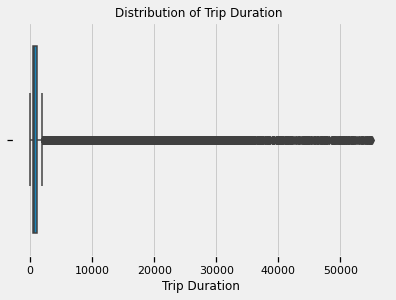

In [86]:
plot_distribution('Trip Duration', ridership_est_2018)

In [87]:
ridership_est_2018 = remove_outliers(ridership_est_2018)

Percent of outliers removed: 5.0232325937559335%


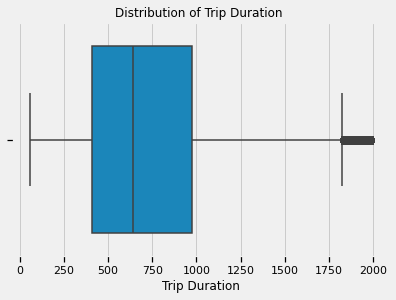

In [88]:
plot_distribution('Trip Duration', ridership_est_2018)

In [89]:
ridership_est_2018.isnull().sum()

Trip Id                0
Trip Duration          0
Start Station Id      54
Start Time             0
Start Station Name     0
End Station Id        54
End Time               0
End Station Name       0
User Type              0
dtype: int64

The station names may need cleaning.

In [90]:
ridership_est_2018 = replace_name(ridership_est_2018)

In [91]:
# fill missing ID with new station names
fill_id_merge(ridership_est_2018)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
3899663,4357633,167,7089.0,2018-11-01 01:01:00-04:00,Church St / Wood St,7077.0,2018-11-01 01:04:00-04:00,College Park South,Member
3899664,4357634,461,7260.0,2018-11-01 01:03:00-04:00,Spadina Ave / Adelaide St W,7333.0,2018-11-01 01:11:00-04:00,King St E / Victoria St,Member
3899665,4357635,604,7281.0,2018-11-01 01:03:00-04:00,Charles St W / Balmuto St - SMART,7002.0,2018-11-01 01:13:00-04:00,St. George St / Bloor St W,Member
3899666,4357637,1133,7047.0,2018-11-01 01:06:00-04:00,University Ave / Gerrard St W,7140.0,2018-11-01 01:25:00-04:00,Macpherson Ave / Spadina Rd,Member
3899667,4357638,753,7032.0,2018-11-01 01:07:00-04:00,Augusta Ave / Dundas St W,7210.0,2018-11-01 01:20:00-04:00,Mary McCormick Rec Centre (Sheridan Ave),Member
...,...,...,...,...,...,...,...,...,...
10871422,4158587,1724,7195.0,2018-10-01 00:47:00-04:00,Ulster St / Bathurst St,7195.0,2018-10-01 01:16:00-04:00,Ulster St / Bathurst St,Member
10871423,4158588,1632,7195.0,2018-10-01 00:49:00-04:00,Ulster St / Bathurst St,7195.0,2018-10-01 01:16:00-04:00,Ulster St / Bathurst St,Member
10871424,4158589,162,7121.0,2018-10-01 00:53:00-04:00,Jarvis St / Dundas St E,7038.0,2018-10-01 00:55:00-04:00,Dundas St W / Yonge St,Member
10871425,4158590,474,7140.0,2018-10-01 00:53:00-04:00,Macpherson Ave / Spadina Rd,7281.0,2018-10-01 01:01:00-04:00,Charles St W / Balmuto St - SMART,Member


In [92]:
ridership_est_2018.isnull().sum()

Trip Id                0
Trip Duration          0
Start Station Id      17
Start Time             0
Start Station Name     0
End Station Id        12
End Time               0
End Station Name       0
User Type              0
dtype: int64

In [93]:
print("Percent of information loss for drop missing values is about: {}".format(2 / len(ridership_est_2018) * 100))

Percent of information loss for drop missing values is about: 0.0001095079751920633


In [94]:
ridership_2018_clean = ridership_est_2018.dropna()

In [95]:
ridership_2018_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826328 entries, 3899663 to 10871426
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             1826328 non-null  int64                     
 1   Trip Duration       1826328 non-null  int64                     
 2   Start Station Id    1826328 non-null  float64                   
 3   Start Time          1826328 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  1826328 non-null  object                    
 5   End Station Id      1826328 non-null  float64                   
 6   End Time            1826328 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    1826328 non-null  object                    
 8   User Type           1826328 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 139.3+ MB


#### **2019 Data**

In [96]:
ridership_est_2019 = time_convert(ridership_2019)

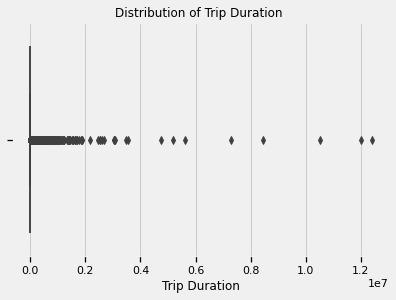

In [97]:
plot_distribution('Trip Duration', ridership_est_2019)

In [98]:
ridership_est_2019 = remove_outliers(ridership_est_2019)

Percent of outliers removed: 4.5134762785279285%


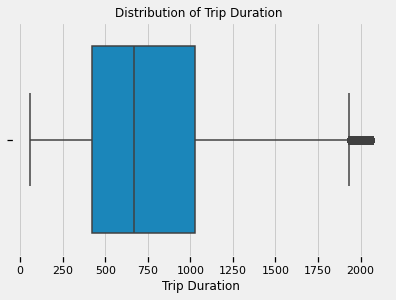

In [99]:
plot_distribution('Trip Duration', ridership_est_2019)

In [100]:
ridership_est_2019.isnull().sum()

Trip Id                 0
Trip Duration           0
Start Station Id        0
Start Time              0
Start Station Name      0
End Station Id        392
End Time                0
End Station Name      392
User Type               0
dtype: int64

In [101]:
# Examine the rows with missing station Id and station name
ridership_est_2019[
    (ridership_est_2019['End Station Name'].isnull()==True) | 
    (ridership_est_2019['End Station Id'].isnull()==True)]

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
5010921,5370500,696,7228.0,2019-06-17 13:21:00-04:00,Queen St W / Roncesvalles Ave,NaN,2019-06-17 13:32:00-04:00,NaN,Member
11326687,7236682,900,7255.0,2019-01-12 19:59:00-05:00,Stewart St / Bathurst St - SMART,NaN,2019-01-12 20:14:00-05:00,NaN,Member
11326953,7237060,1224,7211.0,2019-02-12 08:58:00-05:00,Fort York Blvd / Garrison Rd,NaN,2019-02-12 09:18:00-05:00,NaN,Member
11326982,7237090,1551,7470.0,2019-02-12 09:13:00-05:00,York St / Lake Shore Blvd W,NaN,2019-02-12 09:39:00-05:00,NaN,Member
11326995,7237105,448,7101.0,2019-02-12 09:19:00-05:00,Lower Sherbourne St / The Esplanade,NaN,2019-02-12 09:27:00-05:00,NaN,Member
...,...,...,...,...,...,...,...,...,...
13233198,6772378,1554,7038.0,2019-09-28 18:24:00-04:00,Dundas St W / Yonge St,NaN,2019-09-28 18:50:00-04:00,NaN,Member
13244399,6785059,1100,7438.0,2019-09-30 08:41:00-04:00,High Park Subway - SMART,NaN,2019-09-30 08:59:00-04:00,NaN,Member
13248856,6790168,807,7011.0,2019-09-30 16:53:00-04:00,Wellington St W / Portland St,NaN,2019-09-30 17:06:00-04:00,NaN,Member
13250302,6791678,1808,7016.0,2019-09-30 17:50:00-04:00,Bay St / Queens Quay W (Ferry Terminal),NaN,2019-09-30 18:20:00-04:00,NaN,Member


In [102]:
print("Percent of information loss for drop missing values: {}".format(392 /len(ridership_est_2019) * 100))

Percent of information loss for drop missing values: 0.016827840460052552


It's clear that these rows should be dropped, and they only cause around 0.017% of information loss.

In [103]:
ridership_est_2019 = ridership_est_2019.dropna()

In [104]:
ridership_2019_clean = replace_name(ridership_est_2019)

In [105]:
ridership_2019_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329081 entries, 680308 to 13253294
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2329081 non-null  int64                     
 1   Trip Duration       2329081 non-null  int64                     
 2   Start Station Id    2329081 non-null  float64                   
 3   Start Time          2329081 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  2329081 non-null  object                    
 5   End Station Id      2329081 non-null  float64                   
 6   End Time            2329081 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    2329081 non-null  object                    
 8   User Type           2329081 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 177.7+ MB


#### **2020 Data**

In [106]:
ridership_est_2020 = time_convert(ridership_2020)

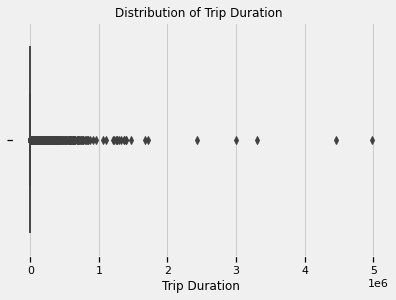

In [107]:
plot_distribution('Trip Duration', ridership_est_2020)

In [108]:
ridership_est_2020 = remove_outliers(ridership_est_2020)

Percent of outliers removed: 4.311910660088181%


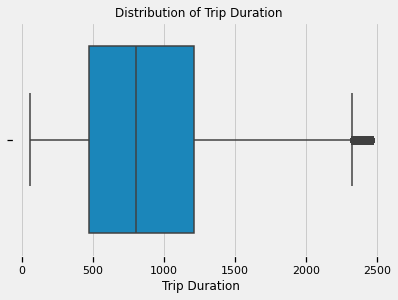

In [109]:
plot_distribution('Trip Duration', ridership_est_2020)

In [110]:
ridership_est_2020.isnull().sum()

Trip Id                  0
Trip Duration            0
Start Station Id         0
Start Time               0
Start Station Name     772
End Station Id         396
End Time                 0
End Station Name      1119
User Type                0
dtype: int64

In [111]:
ridership_est_2020 = replace_name(ridership_est_2020)

In [112]:
fill_id_merge(ridership_est_2020)
fill_name(ridership_est_2020)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
741770,7774422,212,7045.0,2020-01-05 00:02:00-05:00,Bond St / Queen St E,7041.0,2020-01-05 00:05:00-05:00,Edward St / Yonge St,Member
741771,7774423,939,7206.0,2020-01-05 00:04:00-05:00,Claremont St / Dundas St W,7383.0,2020-01-05 00:19:00-05:00,12 Harbour St,Member
741772,7774424,858,7198.0,2020-01-05 00:07:00-05:00,Queen St W / Cowan Ave,7323.0,2020-01-05 00:21:00-05:00,457 King St. W. at Spadina,Member
741773,7774425,244,7372.0,2020-01-05 00:07:00-05:00,King St W / Portland St,7046.0,2020-01-05 00:11:00-05:00,Niagara St / Richmond St W,Member
741774,7774426,689,7361.0,2020-01-05 00:08:00-05:00,Hocken Ave./Vaughan Rd.,7369.0,2020-01-05 00:20:00-05:00,Dupont St / Emerson Ave SMART,Member
...,...,...,...,...,...,...,...,...,...
15310025,9476679,938,7154.0,2020-08-31 23:59:00-04:00,Bathurst Subway Station,7238.0,2020-01-09 00:15:00-05:00,Sorauren/Geoffrey (Sorauren Park) - SMART,Member
15310026,9476681,592,7012.0,2020-08-31 23:59:00-04:00,Elizabeth St / Edward St (Bus Terminal),7100.0,2020-01-09 00:09:00-05:00,Dundas St E / Regent Park Blvd,Member
15310027,9476682,843,7076.0,2020-08-31 23:59:00-04:00,York St / Queens Quay W,7041.0,2020-01-09 00:13:00-05:00,Edward St / Yonge St,Casual
15310028,9476683,420,7038.0,2020-08-31 23:59:00-04:00,Dundas St W / Yonge St,7044.0,2020-01-09 00:06:00-05:00,Church St / Alexander St,Member


In [113]:
ridership_est_2020.isnull().sum()

Trip Id                 0
Trip Duration           0
Start Station Id        0
Start Time              0
Start Station Name      0
End Station Id        396
End Time                0
End Station Name      396
User Type               0
dtype: int64

In [114]:
# Examine the rows with missing station Id and station name
ridership_est_2020[
    (ridership_est_2020['End Station Name'].isnull()==True) | 
    (ridership_est_2020['End Station Id'].isnull()==True)]

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
742130,7775292,559,7042.0,2020-01-05 10:27:00-05:00,Sherbourne St / Wellesley St E,NaN,2020-01-05 10:36:00-05:00,NaN,Member
745038,7778789,1685,7409.0,2020-01-05 19:32:00-05:00,Isabella St / Church St,NaN,2020-01-05 20:00:00-05:00,NaN,Member
745173,7778936,964,7424.0,2020-01-05 19:48:00-05:00,Merton St / Mount Pleasant Rd,NaN,2020-01-05 20:04:00-05:00,NaN,Casual
746226,7780393,540,7285.0,2020-02-05 09:49:00-05:00,Spadina Ave / Harbord St - SMART,NaN,2020-02-05 09:58:00-05:00,NaN,Member
753968,7789397,600,7016.0,2020-03-05 13:46:00-05:00,Bay St / Queens Quay W (Ferry Terminal),NaN,2020-03-05 13:56:00-05:00,NaN,Casual
...,...,...,...,...,...,...,...,...,...
5950588,7443841,696,7033.0,2020-01-30 09:51:00-05:00,Union Station,NaN,2020-01-30 10:02:00-05:00,NaN,Member
5951750,7445141,599,7004.0,2020-01-30 16:10:00-05:00,University Ave / Elm St,NaN,2020-01-30 16:20:00-05:00,NaN,Member
14685953,9827090,1152,7398.0,2020-09-21 20:52:00-04:00,York St / Harbour St,NaN,2020-09-21 21:11:00-04:00,NaN,Member
14938991,9058742,1895,7076.0,2020-09-08 11:28:00-04:00,York St / Queens Quay W,NaN,2020-09-08 11:59:00-04:00,NaN,Casual


In [115]:
print("Percent of information loss for drop missing values: {}".format(396 /len(ridership_est_2020) * 100))

Percent of information loss for drop missing values: 0.014215074799651804


It's clear that these rows with neither End Station Id or End Station Name should be dropped, and they only cause around 0.014% of information loss.

In [116]:
ridership_2020_clean = ridership_est_2020.dropna()

In [117]:
ridership_2020_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2785379 entries, 741770 to 15310029
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2785379 non-null  int64                     
 1   Trip Duration       2785379 non-null  int64                     
 2   Start Station Id    2785379 non-null  float64                   
 3   Start Time          2785379 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  2785379 non-null  object                    
 5   End Station Id      2785379 non-null  float64                   
 6   End Time            2785379 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    2785379 non-null  object                    
 8   User Type           2785379 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 212.5+ MB


#### **2021 Data**

In [118]:
ridership_est_2021 = time_convert(ridership_2021)

In [119]:
ridership_est_2021 = remove_outliers(ridership_est_2021)

Percent of outliers removed: 3.845202845617368%


In [120]:
ridership_est_2021.isnull().sum()

Trip Id                  0
Trip Duration            0
Start Station Id         0
Start Time               0
Start Station Name    3596
End Station Id          47
End Time                 0
End Station Name      3886
User Type                0
dtype: int64

In [121]:
ridership_est_2021 = replace_name(ridership_est_2021)

In [122]:
fill_id_merge(ridership_est_2021)
fill_name(ridership_est_2021)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
6325048,11768884,831,7430.0,2021-01-06 00:00:00-05:00,Marilyn Bell Park Tennis Court,7171.0,2021-01-06 00:14:00-05:00,Ontario Place Blvd / Lake Shore Blvd W (East),Casual
6325049,11768885,666,7054.0,2021-01-06 00:00:00-05:00,Navy Wharf Ct. / Bremner Blvd.,7493.0,2021-01-06 00:11:00-05:00,Sackville St / Eastern Ave - SMART,Member
6325050,11768886,453,7576.0,2021-01-06 00:00:00-05:00,Front St E / Bayview Avenue,7261.0,2021-01-06 00:08:00-05:00,Queens Quay E / Lower Sherbourne St,Member
6325051,11768887,951,7430.0,2021-01-06 00:00:00-05:00,Marilyn Bell Park Tennis Court,7171.0,2021-01-06 00:16:00-05:00,Ontario Place Blvd / Lake Shore Blvd W (East),Casual
6325052,11768888,1130,7171.0,2021-01-06 00:01:00-05:00,Ontario Place Blvd / Lake Shore Blvd W (East),7411.0,2021-01-06 00:20:00-05:00,Little Norway Park,Casual
...,...,...,...,...,...,...,...,...,...
11905542,13392696,455,7054.0,2021-08-31 23:59:00-04:00,Navy Wharf Ct. / Bremner Blvd.,7426.0,2021-01-09 00:06:00-05:00,Fleet St / Garrison Rd (Fort York),Member
11905543,13392697,502,7167.0,2021-08-31 23:59:00-04:00,Queen St E / George St (Moss Park),7389.0,2021-01-09 00:07:00-05:00,College Park- Gerrard Entrance,Member
11905544,13392699,576,7406.0,2021-08-31 23:59:00-04:00,Victoria St / Queen St E,7298.0,2021-01-09 00:09:00-05:00,Bathurst St / Adelaide St W,Member
11905545,13392700,840,7458.0,2021-08-31 23:59:00-04:00,Church St / Lombard St,7199.0,2021-01-09 00:13:00-05:00,College St / Markham St,Casual


In [123]:
ridership_est_2021.isnull().sum()

Trip Id                0
Trip Duration          0
Start Station Id       0
Start Time             0
Start Station Name     0
End Station Id        47
End Time               0
End Station Name      47
User Type              0
dtype: int64

In [124]:
ridership_2021_clean = ridership_est_2021.dropna()

In [125]:
ridership_2021_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3437662 entries, 6325048 to 11905546
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             3437662 non-null  int64                     
 1   Trip Duration       3437662 non-null  int64                     
 2   Start Station Id    3437662 non-null  float64                   
 3   Start Time          3437662 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  3437662 non-null  object                    
 5   End Station Id      3437662 non-null  float64                   
 6   End Time            3437662 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    3437662 non-null  object                    
 8   User Type           3437662 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 262.3+ MB


#### **2022 Data**

In [126]:
ridership_est_2022 = time_convert(ridership_2022)

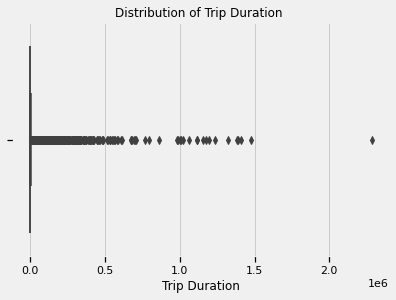

In [127]:
plot_distribution('Trip Duration', ridership_est_2022)

In [128]:
ridership_est_2022 = remove_outliers(ridership_est_2022)

Percent of outliers removed: 3.619192606726662%


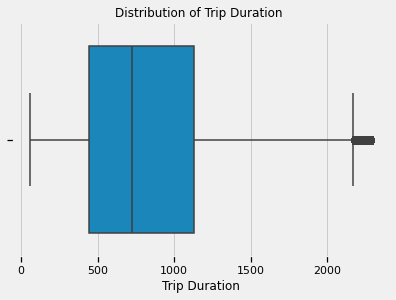

In [129]:
plot_distribution('Trip Duration', ridership_est_2022)

In [130]:
ridership_est_2022.isnull().sum()

Trip Id                   0
Trip Duration             0
Start Station Id          0
Start Time                0
Start Station Name    88783
End Station Id           14
End Time                  0
End Station Name      89757
User Type                 0
dtype: int64

In [131]:
ridership_est_2022 = replace_name(ridership_est_2022)

In [132]:
fill_name(ridership_est_2022)

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
0,16734202,1602,7216.0,2022-01-07 00:00:00-05:00,Wellington St W / Stafford St,7203.0,2022-01-07 00:26:00-05:00,Bathurst St/Queens Quay(Billy Bishop Airport),Casual
1,16734203,990,7033.0,2022-01-07 00:00:00-05:00,Union Station,7474.0,2022-01-07 00:16:00-05:00,Clarence Square,Casual
2,16734204,653,7184.0,2022-01-07 00:00:00-05:00,Ossington Ave / College St,7368.0,2022-01-07 00:11:00-05:00,Lisgar St / Dundas St SMART,Member
3,16734205,811,7199.0,2022-01-07 00:00:00-05:00,College St / Markham St,7533.0,2022-01-07 00:13:00-05:00,Housey St / Dan Leckie Way,Member
4,16734206,1003,7033.0,2022-01-07 00:00:00-05:00,Union Station,7474.0,2022-01-07 00:17:00-05:00,Clarence Square,Casual
...,...,...,...,...,...,...,...,...,...
14291701,18317445,1670,7100.0,2022-08-31 23:58:00-04:00,Dundas St E / Regent Park Blvd,7322.0,2022-01-09 00:26:00-05:00,King St W / Brant St,Casual
14291702,18317447,574,7245.0,2022-08-31 23:58:00-04:00,Tecumseth St / Queen St W - SMART,7069.0,2022-01-09 00:08:00-05:00,Queen St W / Spadina Ave,Member
14291703,18317448,533,7257.0,2022-08-31 23:59:00-04:00,Dundas St W / St. Patrick St,7037.0,2022-01-09 00:08:00-05:00,Bathurst St / Dundas St W,Casual
14291704,18317449,615,7368.0,2022-08-31 23:59:00-04:00,Lisgar St / Dundas St SMART,7521.0,2022-01-09 00:09:00-05:00,Emerson Ave / Bloor St W,Casual


In [133]:
ridership_est_2022.isnull().sum()

Trip Id                 0
Trip Duration           0
Start Station Id        0
Start Time              0
Start Station Name    581
End Station Id         14
End Time                0
End Station Name      621
User Type               0
dtype: int64

Drop the rows with NA data. They only cause insignificant loss of information.

In [134]:
ridership_2022_clean = ridership_est_2022.dropna()

In [135]:
ridership_2022_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2907271 entries, 0 to 14291705
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2907271 non-null  int64                     
 1   Trip Duration       2907271 non-null  int64                     
 2   Start Station Id    2907271 non-null  float64                   
 3   Start Time          2907271 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  2907271 non-null  object                    
 5   End Station Id      2907271 non-null  float64                   
 6   End Time            2907271 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    2907271 non-null  object                    
 8   User Type           2907271 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 221.8+ MB


### Concat the ridership data

In [136]:
ridership_clean = pd.concat([
    ridership_2017_clean,
    ridership_2018_clean,
    ridership_2019_clean,
    ridership_2020_clean,
    ridership_2021_clean,
    ridership_2022_clean
])

In [137]:
ridership_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14631160 entries, 4003950 to 14291705
Data columns (total 9 columns):
 #   Column              Non-Null Count     Dtype                     
---  ------              --------------     -----                     
 0   Trip Id             14631160 non-null  int64                     
 1   Trip Duration       14631160 non-null  int64                     
 2   Start Station Id    14631160 non-null  float64                   
 3   Start Time          14631160 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name  14631160 non-null  object                    
 5   End Station Id      14631160 non-null  float64                   
 6   End Time            14631160 non-null  datetime64[ns, US/Eastern]
 7   End Station Name    14631160 non-null  object                    
 8   User Type           14631160 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 1.1+ GB


In [138]:
ridership_clean.isnull().sum()

Trip Id               0
Trip Duration         0
Start Station Id      0
Start Time            0
Start Station Name    0
End Station Id        0
End Time              0
End Station Name      0
User Type             0
dtype: int64

## Merge the weather data with bike share trip data

In [139]:
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,,
2021-11-01 00:00:00-04:00,9.3,3.1,65.0,0.0,29.0,30.0,16.1,NaN,NaN,Clear
2021-11-01 01:00:00-04:00,8.5,3.1,69.0,0.0,28.0,24.0,16.1,NaN,NaN,Clear
2021-11-01 02:00:00-04:00,8.0,1.4,63.0,0.0,29.0,28.0,16.1,NaN,NaN,Clear
2021-11-01 03:00:00-04:00,7.7,1.1,63.0,0.0,28.0,24.0,16.1,NaN,NaN,Clear
2021-11-01 04:00:00-04:00,7.0,0.7,64.0,0.0,27.0,21.0,16.1,NaN,NaN,Clear


In [140]:
ridership_clean.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type
4003950,1485285,290,7004.0,2017-08-01 01:00:00-04:00,University Ave / Elm St,7007.0,2017-08-01 01:04:00-04:00,College St / Huron St,Member
4003951,1485286,311,7197.0,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,7046.0,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member
4003952,1485287,1053,7196.0,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,7128.0,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member
4003953,1485288,502,7107.0,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,7067.0,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member
4003954,1485289,803,7195.0,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,7163.0,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member


Since the weather data is reported every hour, the time of bike share data can be rounded to the nearest hour.

In [141]:
# Create a 'Start hour' column to round the starting time to the nearest hour
ridership_clean_hour = ridership_clean.copy()
ridership_clean_hour['Start Hour'] = ridership_clean_hour['Start Time'].apply(lambda row: row.round('60min', ambiguous=True, nonexistent='shift_backward'))

In [142]:
# Merging the ridership dataset with weather dataset
df_merged = pd.merge(ridership_clean_hour,weather_clean,left_on="Start Hour",right_index=True,how="inner",sort=False)

In [143]:
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14237708 entries, 4003950 to 14291419
Data columns (total 20 columns):
 #   Column               Non-Null Count     Dtype                     
---  ------               --------------     -----                     
 0   Trip Id              14237708 non-null  int64                     
 1   Trip Duration        14237708 non-null  int64                     
 2   Start Station Id     14237708 non-null  float64                   
 3   Start Time           14237708 non-null  datetime64[ns, US/Eastern]
 4   Start Station Name   14237708 non-null  object                    
 5   End Station Id       14237708 non-null  float64                   
 6   End Time             14237708 non-null  datetime64[ns, US/Eastern]
 7   End Station Name     14237708 non-null  object                    
 8   User Type            14237708 non-null  object                    
 9   Start Hour           14237708 non-null  datetime64[ns, US/Eastern]
 10  Temp (°C) 

In [144]:
df_merged.isnull().sum()

Trip Id                       0
Trip Duration                 0
Start Station Id              0
Start Time                    0
Start Station Name            0
End Station Id                0
End Time                      0
End Station Name              0
User Type                     0
Start Hour                    0
Temp (°C)                     0
Dew Point Temp (°C)           0
Rel Hum (%)                   0
Precip. Amount (mm)           0
Wind Dir (10s deg)            0
Wind Spd (km/h)               0
Visibility (km)               0
Hmdx                    9890669
Wind Chill             13091332
Weather                       0
dtype: int64

In [145]:
df_merged.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,Start Hour,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
4003950,1485285,290,7004.0,2017-08-01 01:00:00-04:00,University Ave / Elm St,7007.0,2017-08-01 01:04:00-04:00,College St / Huron St,Member,2017-08-01 01:00:00-04:00,23.0,17.3,70.0,0.0,34.0,17.0,16.1,28.0,NaN,Clear
4003951,1485286,311,7197.0,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,7046.0,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member,2017-08-01 01:00:00-04:00,23.0,17.3,70.0,0.0,34.0,17.0,16.1,28.0,NaN,Clear
4003952,1485287,1053,7196.0,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,7128.0,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member,2017-08-01 01:00:00-04:00,23.0,17.3,70.0,0.0,34.0,17.0,16.1,28.0,NaN,Clear
4003953,1485288,502,7107.0,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,7067.0,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member,2017-08-01 01:00:00-04:00,23.0,17.3,70.0,0.0,34.0,17.0,16.1,28.0,NaN,Clear
4003954,1485289,803,7195.0,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,7163.0,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member,2017-08-01 01:00:00-04:00,23.0,17.3,70.0,0.0,34.0,17.0,16.1,28.0,NaN,Clear


In [146]:
# Write the merged dataframe to csv (Optional step)
# warning! It takes some time to write to csv. My runtime was about 7 min
# path = os.path.join(os.path.abspath(os.getcwd()), 'data')
# df_merged.to_csv(os.path.join(path, 'bikeshare ridership merged with weather-cleaned.csv'))

# Exploratory Data Analysis

### Distribution of Trip Duration

In [147]:
# #Plot Distribution of Trip Duration in sec for each year
# sns.distplot(ridership_2017_clean['Trip Duration'], kde=True, hist=False, color='r', label='2017') 
# sns.distplot(ridership_2018_clean['Trip Duration'], kde=True, hist=False, color='g', label='2018') 
# sns.distplot(ridership_2019_clean['Trip Duration'], kde=True, hist=False, color='black', label='2019') 
# sns.distplot(ridership_2020_clean['Trip Duration'], kde=True, hist=False, color='blue', label='2020') 
# sns.distplot(ridership_2021_clean['Trip Duration'], kde=True, hist=False, color='grey', label='2021') 
# sns.distplot(ridership_2022_clean['Trip Duration'], kde=True, hist=False, color='purple', label='2022') 

# plt.xlabel('Trip Duration (sec)')
# plt.legend()
# plt.xlim(0,2500)
# plt.title('Distribution of Trip Duration in different years')
# plt.show()

## 1. How does weather influence the way people use bike-share and ride duration?

In [148]:
# Aggregate total number of rides by day
df_daily = df_merged.groupby(pd.Grouper(key = "Start Time", freq = "D")).agg({
    'Temp (°C)':'mean',
    'Dew Point Temp (°C)':'mean',
    'Rel Hum (%)':'mean',
    'Precip. Amount (mm)':'mean',
    'Wind Dir (10s deg)':'mean',
    'Wind Spd (km/h)':'mean',
    'Visibility (km)': 'mean',
    'Hmdx': 'mean',
    'Wind Chill': 'mean',
    'Trip Id':'count', 
    'Trip Duration':'mean'}).reset_index()

# Rename the Trip Id to Number of Trips
df_daily.rename(columns={'Trip Id':'Number of Trips'}, inplace=True)

df_daily.head()

,Start Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Number of Trips,Trip Duration
0,2016-12-31 00:00:00-05:00,1.500000,-3.600000,69.000000,0.0,26.000000,39.000000,16.100000,NaN,NaN,9,515.222222
1,2017-01-01 00:00:00-05:00,1.874268,-4.402301,63.656904,0.0,23.768828,19.418410,16.100000,NaN,-6.000000,478,683.410042
2,2017-01-02 00:00:00-05:00,3.723415,0.920488,82.041463,0.0,6.821951,22.931707,15.690244,NaN,-2.000000,820,621.463415
3,2017-01-03 00:00:00-05:00,4.424971,3.959379,96.825086,0.0,8.330265,14.652474,11.843383,NaN,NaN,869,652.859609
4,2017-01-04 00:00:00-05:00,-2.484864,-7.934218,66.649211,0.0,25.714491,46.650646,15.514634,NaN,-14.923077,1394,621.465567


### 1.1 Features with Positive Correlation in terms of Number of Trips and Trip Duration

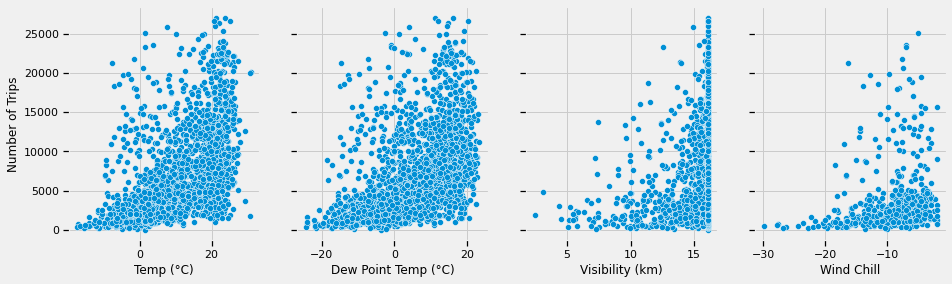

In [149]:
# Create four scatter plots showing number of rides by temperature, Dew point temperature and visibility
# Positive correlation
fig, axes = plt.subplots(1,4,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Temp (°C)","Dew Point Temp (°C)","Visibility (km)", "Wind Chill"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Number of Trips")

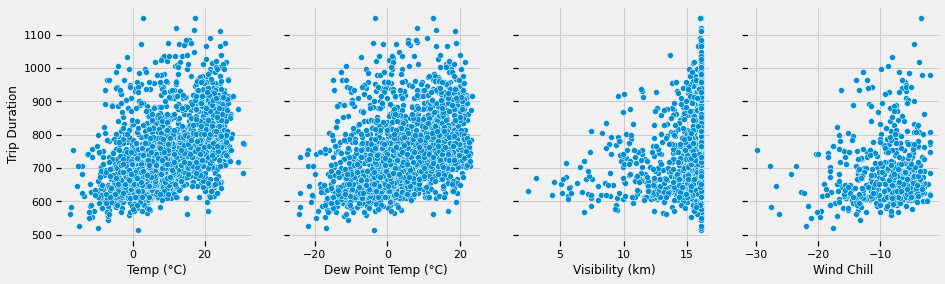

In [203]:
fig, axes = plt.subplots(1,4,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Temp (°C)","Dew Point Temp (°C)","Visibility (km)", "Wind Chill"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Trip Duration")

1.1 A high <b>positive</b> correlation exists between  <b>trip duration and trip duration, and mean temperature, Dew Point Temp, visibility, and wind chill, meaning the warmer the weather, the chiller the wind, and the better visibility</b>, the longer the trips taken.

### 1.2 Features with Nagetive Correlation in terms of Number of Trips and Trip Duration

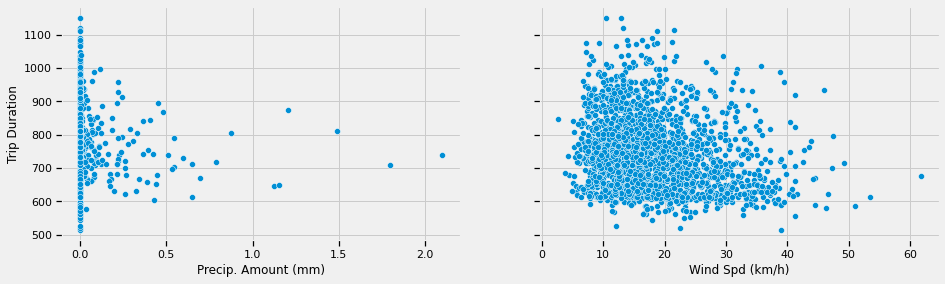

In [150]:
# Create two scatter plots showing number of rides by wind speed and precipitation
# Negative Correlation
fig, axes = plt.subplots(1,2,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Precip. Amount (mm)","Wind Spd (km/h)"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Trip Duration")

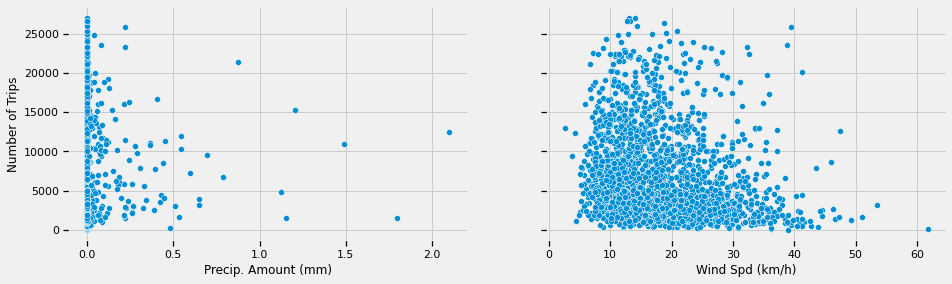

In [151]:
# Create two scatter plots showing number of rides by wind speed and precipitation
# Negative Correlation
fig, axes = plt.subplots(1,2,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Precip. Amount (mm)","Wind Spd (km/h)"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Number of Trips")

1.2 On the other hand, there’s a <b>negetive</b> correlation between <b>trip duration and precipitation as well as wind speed</b>.

### 1.3 Features with No Correlation in terms of Number of Trips and Trip Duration

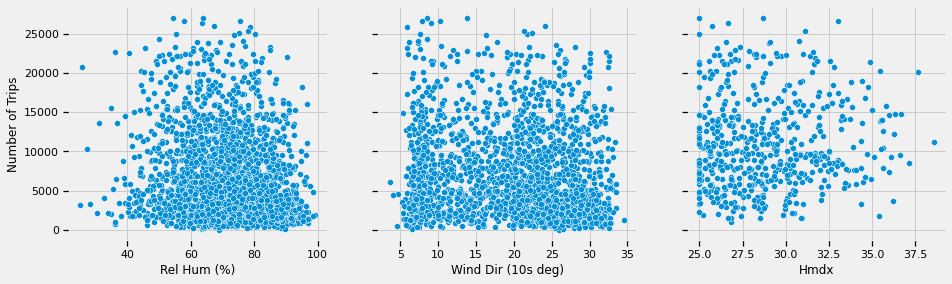

In [152]:
# Create three scatter plots showing number of rides by Humidity, Wind direction and Hmdx
# No correlation
fig, axes = plt.subplots(1,3,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Rel Hum (%)","Wind Dir (10s deg)","Hmdx"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Number of Trips")

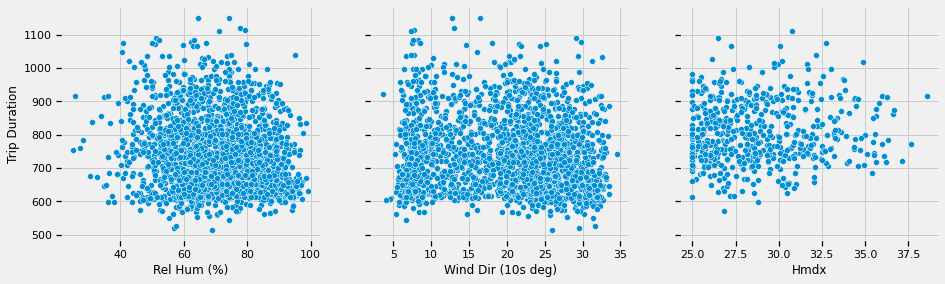

In [153]:
# Create three scatter plots showing number of rides by Humidity, Wind direction and Hmdx
# No correlation
fig, axes = plt.subplots(1,3,figsize=(14, 4),sharey=True)

for i, col in enumerate(["Rel Hum (%)","Wind Dir (10s deg)","Hmdx"]):
    sns.scatterplot(ax=axes[i],data=df_daily,x=col,y="Trip Duration")

1.3 <b>Real Humidity, wind direction and Hmdx</b> have nothing to do with the trip duration (<b>No Correlation</b>).

## 2.	What is the difference between user types?

In [154]:
def isworkday(number):
    if number < 5:
        return True 
    else:
        return False

In [155]:
# Write your code here
data_days = df_merged.groupby(pd.Grouper(key = "Start Time", freq = "D")).agg(
    ride = ('Start Time','count'),
    duration = ('Trip Duration', 'mean'),
    Temp = ('Temp (°C)','mean'),
    precip = ('Precip. Amount (mm)', 'mean'),
    Member = ('User Type', lambda x: (x == 'Member').sum()),
    Casual = ('User Type', lambda x: (x == 'Casual').sum()),
)
data_days['workday'] = data_days.index.weekday
data_days['workday'] = data_days['workday'].apply(isworkday)

# View DataFrame
data_days.head()

,ride,duration,Temp,precip,Member,Casual,workday
Start Time,,,,,,,
2016-12-31 00:00:00-05:00,9,515.222222,1.500000,0.0,9,0,False
2017-01-01 00:00:00-05:00,478,683.410042,1.874268,0.0,410,68,False
2017-01-02 00:00:00-05:00,820,621.463415,3.723415,0.0,752,68,True
2017-01-03 00:00:00-05:00,869,652.859609,4.424971,0.0,852,17,True
2017-01-04 00:00:00-05:00,1394,621.465567,-2.484864,0.0,1360,34,True


### 2.1 Comparison of Casual Members and Annual Members on Working and Non-working days

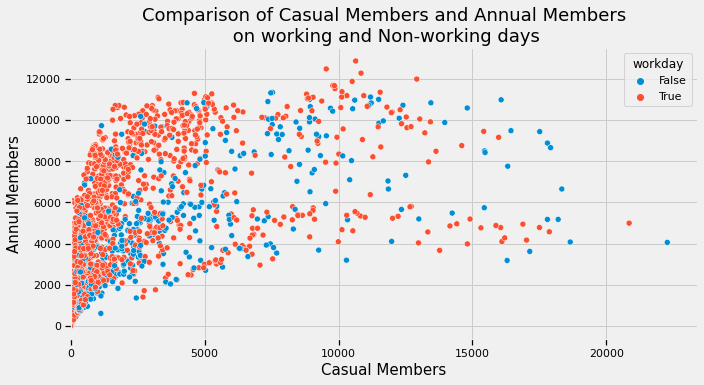

In [156]:
plt.figure(figsize=(10, 5))

graph = sns.scatterplot(data = data_days, x = "Casual", y = "Member", hue = "workday")

plt.title('Comparison of Casual Members and Annual Members\n on working and Non-working days', fontsize = 18)
plt.xlabel('Casual Members', fontsize = 15)
plt.ylabel('Annul Members', fontsize = 15)
graph.set(xlim=(0))


# show the plot
plt.legend(title = 'workday')
plt.show()

2.1 There are more <b>Annual Members</b> using the bikes than <b>Casual Members</b> on <b>working days</b>.

### 2.2 Difference of The Number of Trips between Casual Members and Annual Members on Monthly Basis

In [197]:
def convert_month(month):
    result = []
    for i in month:
        result.append(i.month)
    return result

In [198]:
# create a month column for the creation of season column
month = list(ridership_clean["Start Time"])
month_list = convert_month(month)
ridership_clean['month'] = month_list


In [199]:
# create a dataframe based on the month
data_month = df_merged.groupby(pd.Grouper(key = "Start Time", freq = "M")).agg(
    ride = ('Start Time','count'),
    duration = ('Trip Duration', 'mean'),
    Temp = ('Temp (°C)','mean'),
    precip = ('Precip. Amount (mm)', 'mean'),
    Member = ('User Type', lambda x: (x == 'Member').sum()),
    Casual = ('User Type', lambda x: (x == 'Casual').sum()),
)

# View DataFrame
data_month.head()

,ride,duration,Temp,precip,Member,Casual
Start Time,,,,,,
2016-12-31 00:00:00-05:00,9,515.222222,1.500000,0.0,9,0
2017-01-31 00:00:00-05:00,41061,619.606147,0.314220,0.0,39805,1256
2017-02-28 00:00:00-05:00,40861,639.822227,1.646864,0.0,38748,2113
2017-03-31 00:00:00-04:00,48339,620.697532,1.936621,0.0,46396,1943
2017-04-30 00:00:00-04:00,74565,703.113351,9.278521,0.0,63853,10712


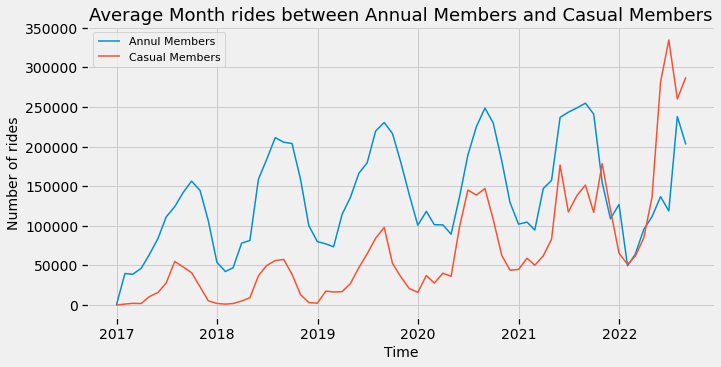

In [200]:
plt.figure(figsize=(10, 5))
plt.title('Average Month rides between Annual Members and Casual Members', fontsize=18)

ax = sns.lineplot(data = data_month, x = data_month.index, y = 'Member', label = 'Annul Members')
ax = sns.lineplot(data = data_month, x = data_month.index, y = 'Casual', label = 'Casual Members')

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Number of rides', fontsize=14)

plt.legend(loc='upper left')
plt.show()

2.2 From year 2017 to 2021, the monthly number of trips of <b>Annual Members</b> is always more than <b>Casual Members </b>. However, in the year of 2022, there is an increasing number of trips made by <b>Casual Members</b>, which exceeds <b>Casual  Members</b>.

In [201]:
ridership_clean

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,User Type,RouteID,month,season
4003950,1485285,290,7004.0,2017-08-01 01:00:00-04:00,University Ave / Elm St,7007.0,2017-08-01 01:04:00-04:00,College St / Huron St,Member,7004-7007,8,Summer
4003951,1485286,311,7197.0,2017-08-01 01:02:00-04:00,Queen St W / Dovercourt Rd,7046.0,2017-08-01 01:07:00-04:00,Niagara St / Richmond St W,Member,7197-7046,8,Summer
4003952,1485287,1053,7196.0,2017-08-01 01:02:00-04:00,Roxton Rd / Harbord St,7128.0,2017-08-01 01:19:00-04:00,Yonge St / Aylmer Ave,Member,7196-7128,8,Summer
4003953,1485288,502,7107.0,2017-08-01 01:02:00-04:00,Cherry St / Distillery Ln,7067.0,2017-08-01 01:10:00-04:00,Yonge St / Harbour St,Member,7107-7067,8,Summer
4003954,1485289,803,7195.0,2017-08-01 01:04:00-04:00,Ulster St / Bathurst St,7163.0,2017-08-01 01:17:00-04:00,Yonge St / Wood St,Member,7195-7163,8,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...
14291701,18317445,1670,7100.0,2022-08-31 23:58:00-04:00,Dundas St E / Regent Park Blvd,7322.0,2022-01-09 00:26:00-05:00,King St W / Brant St,Casual,7100-7322,8,Summer
14291702,18317447,574,7245.0,2022-08-31 23:58:00-04:00,Tecumseth St / Queen St W - SMART,7069.0,2022-01-09 00:08:00-05:00,Queen St W / Spadina Ave,Member,7245-7069,8,Summer
14291703,18317448,533,7257.0,2022-08-31 23:59:00-04:00,Dundas St W / St. Patrick St,7037.0,2022-01-09 00:08:00-05:00,Bathurst St / Dundas St W,Casual,7257-7037,8,Summer
14291704,18317449,615,7368.0,2022-08-31 23:59:00-04:00,Lisgar St / Dundas St SMART,7521.0,2022-01-09 00:09:00-05:00,Emerson Ave / Bloor St W,Casual,7368-7521,8,Summer


### 2.3 The Trips Duration between Casual Members and Annual Members on Monthly Basis

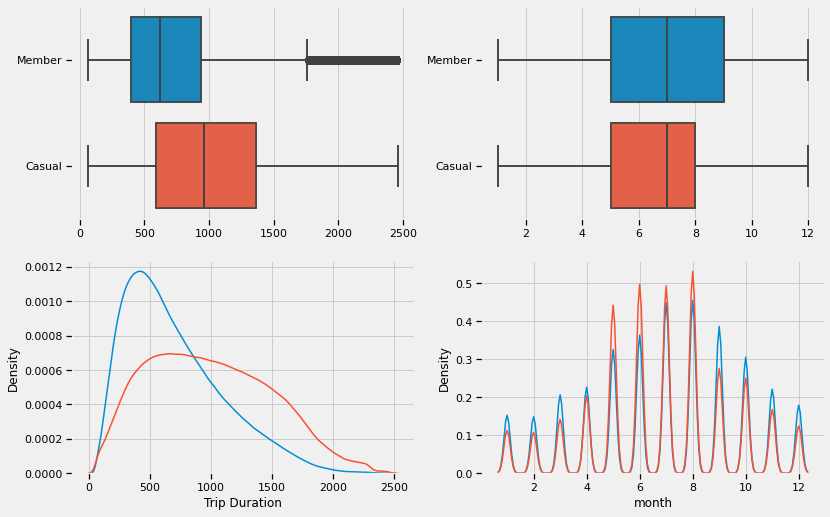

In [202]:
#Plot box pots and density plots to depict distribution of Trip Distance and Trip Duration by user type.
fig, (ax1,ax2) = plt.subplots(2,2,figsize=(12,8))
for i, var in enumerate(['Trip Duration','month']):
    for j,user in enumerate(ridership_clean['User Type'].unique()):
        sns.distplot(ridership_clean[ridership_clean['User Type'] == user][var],hist=False,ax=ax2[i]) 
        sns.boxplot(x=var, y="User Type",data=ridership_clean, ax=ax1[i]).set(xlabel="",ylabel="")

2.3 Annual members tend to take shorter rides compared to casual members who take longer rides but also travel slightly longer distances as well.

## 3. What are the effects of difference seasons and time of the day on the frequencies of rides and duration?

In [160]:
# assign the season to the month
def season(num):
    if num >= 3 and num < 6:
        return "Spring"
    elif num >= 6 and num < 9:
        return "Summer"
    elif num >= 9 and num < 11:
        return "Fall"
    else:
        return "Winter"

In [161]:
data_month["season"] = data_month.index.month
data_month['season'] = data_month['season'].apply(season)
data_month.head()

,ride,duration,Temp,precip,Member,Casual,season
Start Time,,,,,,,
2016-12-31 00:00:00-05:00,9,515.222222,1.500000,0.0,9,0,Winter
2017-01-31 00:00:00-05:00,41061,619.606147,0.314220,0.0,39805,1256,Winter
2017-02-28 00:00:00-05:00,40861,639.822227,1.646864,0.0,38748,2113,Winter
2017-03-31 00:00:00-04:00,48339,620.697532,1.936621,0.0,46396,1943,Spring
2017-04-30 00:00:00-04:00,74565,703.113351,9.278521,0.0,63853,10712,Spring


### 3.1 Season vs. Number of Rides

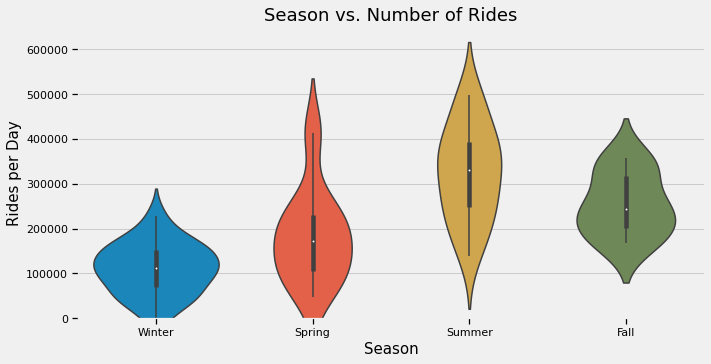

In [162]:
plt.figure(figsize=(10, 5))
plt.title('Season vs. Number of Rides', fontsize=18)

# plot the graph
graph = sns.violinplot(data = data_month, x = "season", y = 'ride')

# set labels
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Rides per Day', fontsize = 15)
graph.set(ylim=(0))

# show the plot
plt.show()

3.1 There are more rides in the <b>Summer and Spring </b> whereas fewer rides in <b>Fall and Winter</b>.

### 3.2 Season vs. Ride Duration

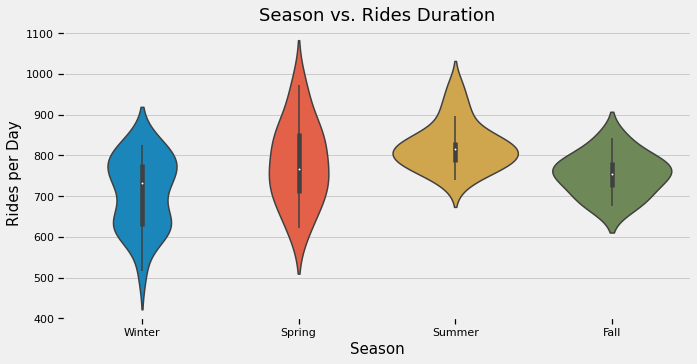

In [163]:
plt.figure(figsize=(10, 5))
plt.title('Season vs. Rides Duration', fontsize=18)

# plot the graph
graph = sns.violinplot(data = data_month, x = "season", y = 'duration')

# set labels
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Rides Duration', fontsize = 15)
graph.set(ylim=(400))

# show the plot
plt.show()

3.2 During <b>Summer and Fall </b> time, users tend to ride long than <b>Winter and Spring time</b>.

## 4. Are there popular route differences in seasons?

### 4.0 The Top 5 most popular route of all time

In [164]:
# assume len(start) = len(end)
def Route(start, end):
    result = []
    temp = 0
    for i in range(len(start)):
        temp = str(int(start[i])) + '-' + str(int(end[i]))
        result.append(temp)
    return result

In [165]:
# create a RouteID list
# put RouteID list into df_merged as a new column
start = list(ridership_clean['Start Station Id'])
end = list(ridership_clean['End Station Id'])

# combine the start stations and end stations together to form a RouteIDs
RouteID = Route(start, end)
ridership_clean['RouteID'] = RouteID

In [166]:
# create a dataframe with the top 5 most popular routes
pop_routes = ridership_clean.groupby("RouteID").agg({"Start Station Name":"max",
                                              "End Station Name":"max",
                                              "Trip Id":"count"}).reset_index()

pop_routes.rename(columns = {'Trip Id':'Number of Trips'}, inplace = True)
pop_routes = pop_routes.sort_values("Number of Trips",ascending=False)

# Create a dataframe depicting the 5 most popular routes
pop_routes.head()

,RouteID,Start Station Name,End Station Name,Number of Trips
77715,7171-7171,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W,11895
146550,7354-7354,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit),11472
79400,7175-7175,HTO Park (Queens Quay W),HTO Park (Queens Quay W),8971
142944,7344-7354,Cherry Beach,Tommy Thompson Park (Leslie Street Spit),8567
89819,7203-7076,Bathurst St/Queens Quay(Billy Bishop Airport),York St / Queens Quay W,8008


4.0 The top 5 most popular routes are:
    
    1) Ontario Place Blvd / Lakeshore Blvd W - Ontario Place Blvd / Lakeshore Blvd W
    2) Tommy Thompson Park (Leslie Street Spit)	- Tommy Thompson Park (Leslie Street Spit)
    3）HTO Park (Queens Quay W) - HTO Park (Queens Quay W)	
    4）Cherry Beach - Tommy Thompson Park (Leslie Street Spit)
    5）Bathurst St/Queens Quay(Billy Bishop Airport)	- York St / Queens Quay W
    
The start stations and end stations of the first three routes are the same, meaning these places(parks) are popular for bikers. All of these places are parks or places suitable for biking.

### 4.1 The Top 5 most popular route in different seasons

In [169]:
# create a season column based on the month column
ridership_clean['season'] = ridership_clean['month'].apply(season)

#### 4.1.1 The Top 5 most popular route in Summer

In [170]:
# dataframe of the season of summer
summer = ridership_clean[ridership_clean.season == 'Summer']

In [171]:
# create a dataframe with the top 5 most popular routes
pop_routes_summer= summer.groupby("RouteID").agg({"Start Station Name":"max",
                                              "End Station Name":"max",
                                              "Trip Id":"count"}).reset_index()

pop_routes_summer.rename(columns = {'Trip Id':'Number of Trips'}, inplace = True)
pop_routes_summer= pop_routes_summer.sort_values("Number of Trips",ascending=False)

# Create a dataframe depicting the 5 most popular routes
pop_routes_summer.head()

,RouteID,Start Station Name,End Station Name,Number of Trips
71291,7171-7171,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W,5541
132959,7354-7354,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit),5004
72822,7175-7175,HTO Park (Queens Quay W),HTO Park (Queens Quay W),4326
129934,7344-7354,Cherry Beach,Tommy Thompson Park (Leslie Street Spit),3631
114589,7288-7288,Humber Bay Shores Park West,Humber Bay Shores Park West,3513


4.1.1 The top 5 most popular routes in summer are:
    
    1) Ontario Place Blvd / Lakeshore Blvd W - Ontario Place Blvd / Lakeshore Blvd W
    2) Tommy Thompson Park (Leslie Street Spit)	- Tommy Thompson Park (Leslie Street Spit)
    3）HTO Park (Queens Quay W) - HTO Park (Queens Quay W)	
    4）Cherry Beach - Tommy Thompson Park (Leslie Street Spit)
    5）Humber Bay Shores Park West - Humber Bay Shores Park West

#### 4.1.2 The Top 5 most popular route in Fall

In [172]:
fall = ridership_clean[ridership_clean.season == 'Fall']

In [173]:
pop_routes_fall = fall.groupby("RouteID").agg({"Start Station Name":"max",
                                              "End Station Name":"max",
                                              "Trip Id":"count"}).reset_index()

pop_routes_fall.rename(columns = {'Trip Id':'Number of Trips'}, inplace = True)
pop_routes_fall = pop_routes_fall.sort_values("Number of Trips",ascending=False)

# Create a dataframe depicting the 5 most popular routes
pop_routes_fall.head()

,RouteID,Start Station Name,End Station Name,Number of Trips
61747,7171-7171,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W,1775
113245,7354-7354,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit),1704
24575,7059-7033,Front St W / Blue Jays Way,Union Station,1484
70978,7203-7076,Bathurst St/Queens Quay(Billy Bishop Airport),York St / Queens Quay W,1394
110972,7344-7354,Cherry Beach,Tommy Thompson Park (Leslie Street Spit),1342


4.1.2 The top 5 most popular routes in fall are:
    
    1) Ontario Place Blvd / Lakeshore Blvd W - Ontario Place Blvd / Lakeshore Blvd W
    2) Tommy Thompson Park (Leslie Street Spit)	- Tommy Thompson Park (Leslie Street Spit)
    3）Front St W / Blue Jays Way - Union Station
    4）Bathurst St/Queens Quay(Billy Bishop Airport) - York St / Queens Quay W
    5）Cherry Beach - Tommy Thompson Park (Leslie Street Spit)

#### 4.1.3 The Top 5 most popular route in Winter

In [174]:
winter = ridership_clean[ridership_clean.season == 'Winter']

In [175]:
pop_routes_winter = winter.groupby("RouteID").agg({"Start Station Name":"max",
                                              "End Station Name":"max",
                                              "Trip Id":"count"}).reset_index()

pop_routes_winter.rename(columns = {'Trip Id':'Number of Trips'}, inplace = True)
pop_routes_winter = pop_routes_winter.sort_values("Number of Trips",ascending=False)

# Create a dataframe depicting the 5 most popular routes
pop_routes_winter.head()

,RouteID,Start Station Name,End Station Name,Number of Trips
24429,7059-7033,Front St W / Blue Jays Way,Union Station,1866
111629,7354-7354,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit),1722
60888,7171-7171,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W,1394
70037,7203-7076,Bathurst St/Queens Quay(Billy Bishop Airport),York St / Queens Quay W,1296
30992,7076-7203,York St / Queens Quay W,Bathurst St/Queens Quay(Billy Bishop Airport),1162


4.1.3 The top 5 most popular routes in winter are:
    
    1) Front St W / Blue Jays Way - Union Station
    2) Tommy Thompson Park (Leslie Street Spit) - Tommy Thompson Park (Leslie Street Spit)
    3）Ontario Place Blvd / Lakeshore Blvd W - Ontario Place Blvd / Lakeshore Blvd W
    4）Bathurst St/Queens Quay(Billy Bishop Airport)	 - York St / Queens Quay W
    5）York St / Queens Quay W - Bathurst St/Queens Quay(Billy Bishop Airport)

#### 4.1.4 The Top 5 most popular route in Spring

In [176]:
spring = ridership_clean[ridership_clean.season == 'Spring']

In [177]:
pop_routes_spring = spring.groupby("RouteID").agg({"Start Station Name":"max",
                                              "End Station Name":"max",
                                              "Trip Id":"count"}).reset_index()

pop_routes_spring.rename(columns = {'Trip Id':'Number of Trips'}, inplace = True)
pop_routes_spring = pop_routes_spring.sort_values("Number of Trips",ascending=False)

# Create a dataframe depicting the 5 most popular routes
pop_routes_spring.head()

,RouteID,Start Station Name,End Station Name,Number of Trips
63615,7171-7171,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W,3185
117160,7354-7354,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit),3042
114727,7344-7354,Cherry Beach,Tommy Thompson Park (Leslie Street Spit),2448
64947,7175-7175,HTO Park (Queens Quay W),HTO Park (Queens Quay W),2371
101696,7288-7288,Humber Bay Shores Park West,Humber Bay Shores Park West,2239


4.1.3 The top 5 most popular routes in spring are:
    
    1) Ontario Place Blvd / Lakeshore Blvd W - Ontario Place Blvd / Lakeshore Blvd W
    2) Tommy Thompson Park (Leslie Street Spit) - Tommy Thompson Park (Leslie Street Spit)
    3）Cherry Beach - Tommy Thompson Park (Leslie Street Spit)	
    4）HTO Park (Queens Quay W) - HTO Park (Queens Quay W)
    5）Humber Bay Shores Park West - Humber Bay Shores Park West

## 5. What is the impact of major social changes? Special occasions such as the pandemic or the introduction of e-bikes.

### 5.1 Number of Rides and Ride Duration per Year

In [191]:
# create a dataframe based on the month
data_year = ridership_clean.groupby(pd.Grouper(key = "Start Time", freq = "Y")).agg(
    ride = ('Start Time','count'),
    duration = ('Trip Duration', 'mean')
)
data_year.index = data_year.index.year

# View DataFrame
data_year.head()

,ride,duration
Start Time,,
2016,58,577.396552
2017,1345412,714.297991
2018,1826297,728.522486
2019,2329081,757.133911
2020,2785379,872.845455


In [192]:
data_year = data_year.drop(2016)

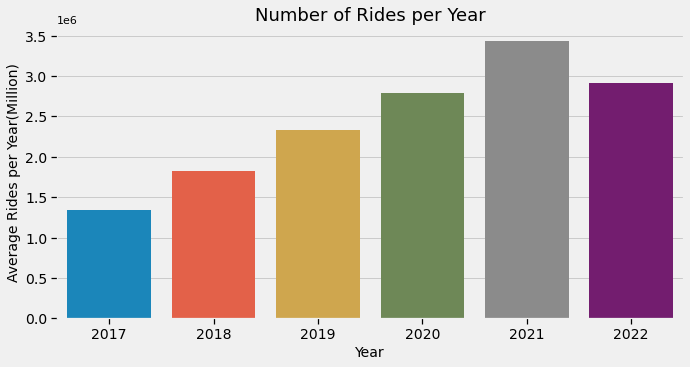

In [205]:
# figure size
plt.figure(figsize=(10, 5))
plt.title('Number of Rides per Year', fontsize=18)

# plot the graph
ax = sns.barplot(data=data_year, x = data_year.index, y = 'ride')

# set x-axis amd y-axis
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Rides per Year(Million)', fontsize=14)

# show plot
plt.show()

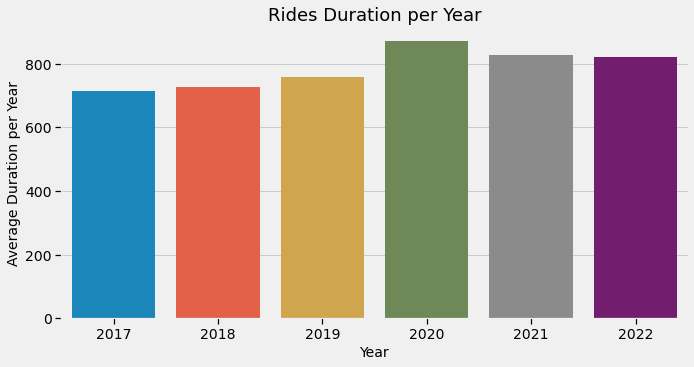

In [195]:
# figure size
plt.figure(figsize=(10, 5))
plt.title('Rides Duration per Year', fontsize=18)

# plot the graph
ax = sns.barplot(data=data_year, x = data_year.index, y = 'duration')

# set x-axis amd y-axis
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Duration per Year', fontsize=14)

# show plot
plt.show()

5.1 There is <b>no</b> differece of <b>number of rides</b> and <b>ride duration</b> between <b>before</b> and <b>during pandemic</b>.

### 5.2 Top 5 Busiest Start Stations — Before Pandemic


In [181]:
# create two dataframs of before pandemic and during

ridership_before_pandemic = pd.concat([
    ridership_2017_clean,
    ridership_2018_clean,
])

ridership_during_pandemic = pd.concat([
    ridership_2019_clean,
    ridership_2020_clean,
    ridership_2021_clean,
    ridership_2022_clean

])

In [182]:
def five_busiest_stations(dataframe):
    return dataframe.value_counts().head().reset_index()\
            .rename(columns={"index":"Start Station","Start Station Name":"Number of Trips"})

In [183]:
busieststations_before_pandemic = five_busiest_stations(ridership_before_pandemic["Start Station Name"])
busieststations_before_pandemic.head()

,Start Station,Number of Trips
0,Union Station,39710
1,Bay St / Wellesley St W,36187
2,York St / Queens Quay W,35477
3,Simcoe St / Wellington St South,34965
4,Dundas St W / Yonge St,34661


5.2 The top 5 most busiest stations in before pandemic are:
    
    1) Union Station	
    2) Bay St / Wellesley St W	
    3）York St / Queens Quay W	
    4）Simcoe St / Wellington St South
    5）Dundas St W / Yonge St	

### 5.3 Top 5 Busiest Start Stations — During Pandemic


In [184]:
busieststations_during_pandemic = five_busiest_stations(ridership_during_pandemic["Start Station Name"])
busieststations_during_pandemic.head()

,Start Station,Number of Trips
0,York St / Queens Quay W,109966
1,Lake Shore Blvd W / Ontario Dr,88294
2,Queens Quay E / Lower Sherbourne St,84039
3,Bay St / Queens Quay W (Ferry Terminal),83727
4,Ontario Place Blvd / Lake Shore Blvd W (East),82109


5.3 The top 5 most busiest stations in during pandemic are:
    
    1) York St / Queens Quay W	
    2) Lake Shore Blvd W / Ontario Dr		
    3）Queens Quay E / Lower Sherbourne St		
    4）Bay St / Queens Quay W (Ferry Terminal)
    5）Ontario Place Blvd / Lake Shore Blvd W (East)		

# ML Model

# Conclusions